In [3]:
import numpy as np
import pandas as pd
import matplotlib
print(matplotlib.__version__)
matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.lines as mlines
from glob import glob
from collections import Counter
import ns
import history_cmc as hic
import math
import scipy
from scipy import stats
import matplotlib.cm as cm
import matplotlib as mpl
import random
from random import shuffle
import json
import scripts
import scripts1
import scripts2
import scripts3
import dynamics as dyn

import ecc_calc as gwcalc
import unit_convert as uc
import merger_rate_calculator as mr
import ns_tidalcapture as tc


%matplotlib inline

matplotlib.rcParams.update({'font.size': 24})
      
twopi=2.*np.pi
yearsc=3.1557*10**7
Kconst=9.87*10**-48 ##yr/G^2
Gconst=6.674*10**-8 ##cm3*g-1*s-2
Gconst_sun = 4.30091*10**-3 ##pc*M_sun**-1*(km/s)2
clight=3*10**10 ##cm/s
Msun=2*10**33 ##gram
AU=1.496*10**13  ##cm
AU_Rsun=214.93946938362 ##AU to R_sun
PC=3.086*10**18  ##cm
PC_Rsun = 44334448.0068964 ##pc to R_sun
PC_AU = 206265 ##pc to AU

testpath = '/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/path_rvgrid.dat'
paths = np.genfromtxt(testpath, dtype=str)

prop_init = {}; prop_finl = {}; prop_des = {}

##Extracting the data from the rv_grid (the most recent test)
for ii in range(len(paths)):
    prop_init_temp, prop_finl_temp, prop_des_temp = tc.find_tc_properties(paths[ii])
    prop_init[str(ii)] = prop_init_temp; prop_finl[str(ii)] = prop_finl_temp
    prop_des[str(ii)] = prop_des_temp
    print(len(prop_init[str(ii)]['id0']), len(prop_finl[str(ii)]['id0']), len(prop_des[str(ii)]['id0']))


##Separate giant collisions and tidal capture
index_tc_bin = []
index_coll_bin = []
index_tc_des = []
index_coll_des = []

for jj in range(len(paths)):
    index_tc_bin.append([]); index_coll_bin.append([])
    index_tc_des.append([]); index_coll_des.append([])
    types_bin = prop_init[str(jj)]['type']
    for i in range(len(types_bin)):
        if types_bin[i] == 'SS_COLL_Giant': index_coll_bin[jj].append(i)
        if types_bin[i] == 'SS_COLL_TC_P': index_tc_bin[jj].append(i)
        
    types_des = prop_des[str(jj)]['type']
    for i in range(len(types_des)):
        if types_des[i] == 'SS_COLL_Giant': index_coll_des[jj].append(i)
        if types_des[i] == 'SS_COLL_TC_P': index_tc_des[jj].append(i)
    
    #index_coll = index_coll_bin+index_coll_des
    #index_tc = index_tc_bin+index_tc_des

    print(len(index_coll_bin[jj]), len(index_tc_bin[jj]))
    print(len(index_coll_des[jj]), len(index_tc_des[jj]))

all_sscoll = {}
index_sticky = []; index_tccoll = []
index_gmerge = []; index_tde = []
index_bhns_tde =[]
##Extract data from the collision file
for kk in range(len(paths)):
    index_sticky.append([]); index_tccoll.append([])
    index_gmerge.append([]); index_tde.append([])
    index_bhns_tde.append([])
    
    collfile = paths[kk]+'initial.collision.log'
    colldata = scripts1.readcollfile(collfile)
    #print(colldata)

    all_sscoll[str(kk)] = {'time':[], 'idm':[], 'id0':[], 'id1':[], 'mm':[], 'm0':[], 'm1':[], 'km':[], 'k0':[], 'k1':[], 
                 'r0':[], 'r1':[], 'rclu':[], 'vinf':[], 'rperi':[], 'coll_mult':[]}
    for k in range(len(colldata)):
        line = colldata[k].split()
        #print(line)
        if line[1]=='single-single':
            all_sscoll[str(kk)]['time'].append(float(line[0]))
            all_sscoll[str(kk)]['idm'].append(int(line[3])); all_sscoll[str(kk)]['id0'].append(int(line[5])); all_sscoll[str(kk)]['id1'].append(int(line[7]))
            all_sscoll[str(kk)]['mm'].append(float(line[4])); all_sscoll[str(kk)]['m0'].append(float(line[6])); all_sscoll[str(kk)]['m1'].append(float(line[8]))
            all_sscoll[str(kk)]['rclu'].append(float(line[9]))
            all_sscoll[str(kk)]['km'].append(int(line[10])); all_sscoll[str(kk)]['k0'].append(int(line[11])); all_sscoll[str(kk)]['k1'].append(int(line[12]))
            all_sscoll[str(kk)]['vinf'].append(float(line[14]))
            all_sscoll[str(kk)]['r0'].append(float(line[15])); all_sscoll[str(kk)]['r1'].append(float(line[16]))
            all_sscoll[str(kk)]['rperi'].append(float(line[17])); all_sscoll[str(kk)]['coll_mult'].append(float(line[18])) 
        

    ##Separate ss collisions into different categories
    coll_des_id0 = np.take(prop_des[str(kk)]['id0'], index_coll_des[kk])
    coll_des_id1 = np.take(prop_des[str(kk)]['id1'], index_coll_des[kk])

    tc_des_id0 = np.take(prop_des[str(kk)]['id0'], index_tc_des[kk])
    tc_des_id1 = np.take(prop_des[str(kk)]['id1'], index_tc_des[kk])


    for k in range(len(all_sscoll[str(kk)]['k0'])):
        if all_sscoll[str(kk)]['id0'][k] in coll_des_id0:
            index_gmerge[kk].append(k)
            index_tccoll[kk].append(k)
        elif all_sscoll[str(kk)]['id0'][k] in tc_des_id0:
            index_tde[kk].append(k)
            index_tccoll[kk].append(k)
        elif all_sscoll[str(kk)]['coll_mult'][k]==1.:
            index_sticky[kk].append(k)
        #if all_sscoll['k0'][k]>=13 or all_sscoll['k1'][k]>=13:
        #    print(all_sscoll['id0'][k], all_sscoll['id1'][k])
    #elif all_sscoll['k0'][k]>=13 or all_sscoll['k1'][k]>=13:
    #    index_tde.append(k)
    #elif (2<=all_sscoll['k0'][k]<=9 and all_sscoll['k0'][k]!=7) or (2<=all_sscoll['k1'][k]<=9 and all_sscoll['k1'][k]!=7):
    #    index_gmerge.append(k)
    #    print(all_sscoll['id0'][k], all_sscoll['id1'][k], all_sscoll['k0'][k], all_sscoll['k1'][k], all_sscoll['m0'][k],
    #         all_sscoll['m1'][k])
    
        else:
            index_bhns_tde[kk].append(k)
                 
    print(len(index_sticky[kk]), len(index_tccoll[kk]))
    print(len(index_gmerge[kk]), len(index_tde[kk]))
    print(len(index_bhns_tde[kk]))

    ##Check what are the others
    other_id0 = np.take(all_sscoll[str(kk)]['id0'], index_bhns_tde[kk])
    other_k0 = np.take(all_sscoll[str(kk)]['k0'], index_bhns_tde[kk])
    other_k1 = np.take(all_sscoll[str(kk)]['k1'], index_bhns_tde[kk])

    print(other_k0, other_k1)
    
print(len(prop_init))

2.1.2
n_giant_coll: 934 n_tc_merged: 121
1204 1204 1055
n_giant_coll: 562 n_tc_merged: 108
969 969 670
n_giant_coll: 282 n_tc_merged: 35
413 413 317
n_giant_coll: 256 n_tc_merged: 25
389 389 281
n_giant_coll: 202 n_tc_merged: 25
320 320 227
n_giant_coll: 165 n_tc_merged: 21
261 261 186
n_giant_coll: 71 n_tc_merged: 4
138 138 75
n_giant_coll: 33 n_tc_merged: 4
93 

/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/software/anaconda3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/software/anaconda3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/software/anaconda3.6/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/software/anaconda3.6/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    iolo

93 37
n_giant_coll: 18 n_tc_merged: 4
46 46 22
n_giant_coll: 5 n_tc_merged: 0
23 23 5
664 540
934 121
537 432
562 108
218 195
282 35
168 221
256 25
127 193
202 25
103 158
165 21
39 99
71 4
28 65
33 4
7 39
18 4
4 19
5 0
919 1055
934 121
96
[14 14  0 14  0  0  0 14 14  0  0 14 14 14 14 14  1  1  0  1 14 14 14  1
  0  1 14 14 14  0 14  1 14 14  0  0 14 14  1  1  0  1 14  1 14 14 14 14
 14 14 14  0  0  1 14  1 14  1  0 14 14 14 14  0 14 14  0 14 14  0  1 14
 14  1 14 14  1 14  1  1 14 13 14 13 13 13  1 13  1  0  1  0  1  1  0 13] [ 0  0 14  0 14 14 14  0  0 14 14  0  0  0  0  1 14 14 14 14  0  0  0 14
 14 14  1  0  0 14  0 14  1  0 14 14  1  1 14 14 14 14  1 14  0  1  1  0
  1  0  1 14 14 14  0 14  0 14 14  1  1  0  1 14  0  1 14  1  1 14 14  1
  1 14  1  0 13  0 14 14  1  1  1  1  1  0 13  1 13 13 13 13 13 13 13  1]
789 670
562 108
80
[14 14 14  0 14 14  0 14  1  1  1  0  0 14  0  0  0  0 14 14  1 14 14  0
 14  1 14  0 14 14 14  1  0  0 14  1  1  1  0 14  0 14  0 14  0 14  0 14
  0 14 14 

In [4]:
##Extract data from properties by key
def extract_key(key_str):
    init_list = []; finl_list = []; des_list = []
    for i in range(len(prop_init)):
        if key_str != 'rperi' and key_str != 'vinf' and key_str != 'sma' and key_str != 'ecc':
            init_list = init_list + list(prop_init[str(i)][key_str])
            finl_list = finl_list + list(prop_finl[str(i)][key_str])
        elif key_str == 'sma' or key_str == 'ecc':
            finl_list = finl_list + list(prop_finl[str(i)][key_str])
        elif key_str == 'rperi' or key_str == 'vinf':
            init_list = init_list + list(prop_init[str(i)][key_str])
            
    for j in range(len(prop_des)):
        if key_str != 'sma' and key_str != 'ecc':
            des_list = des_list + list(prop_des[str(j)][key_str])
                   
    return init_list, finl_list, des_list



def extract_key_index(key_str, index_name, flag_name):
    init_list_index = []; finl_list_index = []; des_list_index = []
    if flag_name == 'bin':
        for i in range(len(prop_init)):
            if key_str != 'rperi' and key_str != 'vinf' and key_str != 'sma' and key_str != 'ecc':
                init_list_index.append(list(np.take(prop_init[str(i)][key_str], index_name[i]))) 
                finl_list_index.append(list(np.take(prop_finl[str(i)][key_str], index_name[i])))
            elif key_str == 'sma' or key_str == 'ecc':
                finl_list_index.append(list(np.take(prop_finl[str(i)][key_str], index_name[i])))
            elif key_str == 'rperi' or key_str == 'vinf':
                init_list_index.append(list(np.take(prop_init[str(i)][key_str], index_name[i])))
    else:
        for j in range(len(prop_des)):
            if key_str != 'sma' and key_str != 'ecc':
                des_list_index.append(list(np.take(prop_des[str(j)][key_str], index_name[j]))) 
        
    return init_list_index, finl_list_index, des_list_index


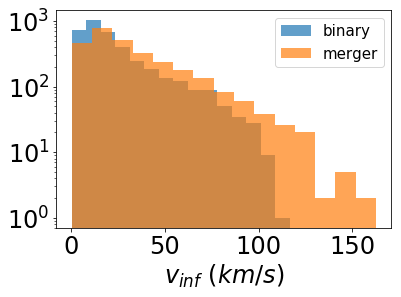

In [3]:
##plot the distribution of v_inf
vinf_init, vinf_finl, vinf_des = extract_key('vinf')

plt.figure()
plt.hist(vinf_init, bins = 15, alpha=0.7, label = 'binary')
plt.hist(vinf_des, bins = 15, alpha=0.7, label = 'merger')
plt.yscale('log')
plt.xlabel(r'$v_{inf}\ (km/s)$')
plt.legend(loc='best', fontsize=15)

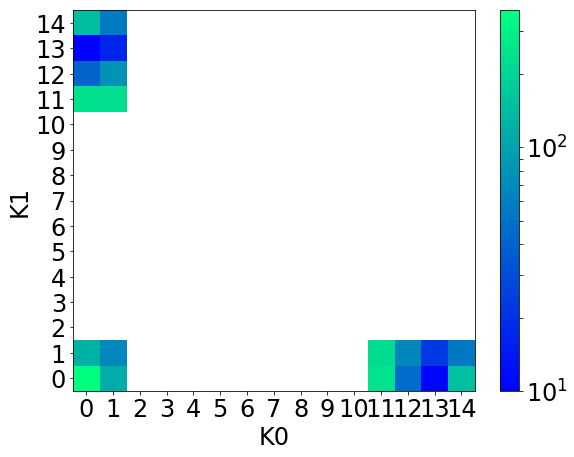

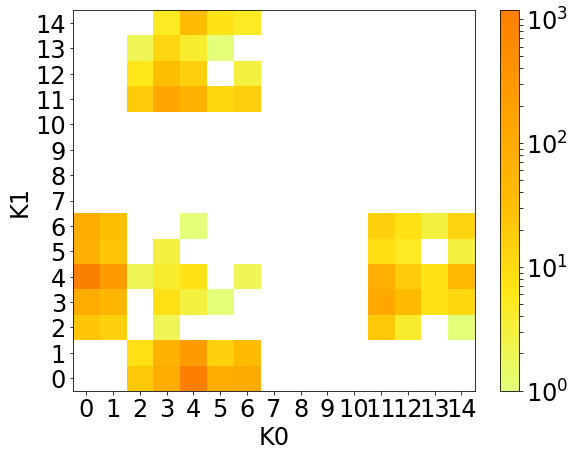

In [3]:
##plot the types of stars for tidal capture
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tck0_init_emp, tck0_finl_emp, tck0_des_index = extract_key_index('k0', index_tc_des, 'des')
tck1_init_emp, tck1_finl_emp, tck1_des_index = extract_key_index('k1', index_tc_des, 'des')

tc_k0 = []; tc_k1 = []
for k in range(len(paths)):
    tc_k0.append(tck0_init_index[k] + tck0_des_index[k])
    tc_k1.append(tck1_init_index[k] + tck1_des_index[k])

#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#print(tc_k0, tc_k1)

K0 = []; K1 = []
for k in range(len(paths)):
    K0 = K0 + [x - 0.5 for x in tc_k0[k]]
    K1 = K1 + [Y - 0.5 for Y in tc_k1[k]]
    
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='winter')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))    
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()


##plot the types of stars for giant-giant collisions
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')
collk0_init_emp, collk0_finl_emp, collk0_des_index = extract_key_index('k0', index_coll_des, 'des')
collk1_init_emp, collk1_finl_emp, collk1_des_index = extract_key_index('k1', index_coll_des, 'des')

coll_k0 = []; coll_k1 = []
for k in range(len(paths)):
    coll_k0.append(collk0_init_index[k] + collk0_des_index[k])
    coll_k1.append(collk1_init_index[k] + collk1_des_index[k])

#coll_k0_bin = np.take(prop_init['k0'], index_coll_bin)
#coll_k1_bin = np.take(prop_init['k1'], index_coll_bin)
#coll_k0_des = np.take(prop_des['k0'], index_coll_des)
#coll_k1_des = np.take(prop_des['k1'], index_coll_des)
#print(coll_k0, coll_k1)

K0 = []; K1 = []
for k in range(len(paths)):
    K0 = K0 + [x - 0.5 for x in coll_k0[k]]
    K1 = K1 + [Y - 0.5 for Y in coll_k1[k]]
    
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='Wistia')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()

In [4]:
##Compare final and initial star types of tidal capture binaries
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')

#tc_k0_init = np.take(prop_init['k0'], index_tc_bin)
#tc_k1_init = np.take(prop_init['k1'], index_tc_bin)
#tc_k0_finl = np.take(prop_finl['k0'], index_tc_bin)
#tc_k1_finl = np.take(prop_finl['k1'], index_tc_bin)


for i in range(len(paths)):
    k0_diff = [x - y for x, y in zip(tck0_finl_index[i], tck0_init_index[i])]
    k1_diff = [x - y for x, y in zip(tck1_finl_index[i], tck1_init_index[i])]
    #print(k0_diff, k1_diff)
    
    print(np.nonzero(k0_diff), np.nonzero(k1_diff))

    
##Check final giant-giant collisions star types
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')
collid0_init_index, collid0_finl_index, collid0_des_emp = extract_key_index('id0', index_coll_bin, 'bin')
collid1_init_index, collid1_finl_index, collid1_des_emp = extract_key_index('id1', index_coll_bin, 'bin')

n_not7 = 0
for j in range(len(paths)):
    for i in range(len(collk0_init_index[j])):
        if 2<=collk0_init_index[j][i]<=9 and collk0_init_index[j][i]!=7:
            if collk0_finl_index[j][i]!=7: 
                print(collid0_init_index[j][i], collk0_init_index[j][i], collk0_finl_index[j][i])
                n_not7+=1
        if 2<=collk1_init_index[j][i]<=9 and collk1_init_index[j][i]!=7:
            if collk1_finl_index[j][i]!=7: 
                print(collid1_init_index[j][i], collk1_init_index[j][i], collk1_finl_index[j][i])
                n_not7+=1

print(n_not7)
##Does this look right?
##How exactly does stripping envelope work?

(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
(array([], dtype=int64),) (array([], dtype=int64),)
1038841 5 14
291088 5 14
682089 5 14
308982 5 14
19650 5 14
1184896 5 14
744186 5 14
614243 5 14
699515 5 13
998650 5 8
782924 5 8
490730 5 8
267884 5 8
45545 5 8
292783 5 8
125347 5 8
1268845 5 8
514768 5 8
762286 5 8
629218 5 8
238809 5 8
530695 5 8
306304 5 8
391922 5 8
160231 6 13
78050 6 13
466285 6 13
222762 6 13
104960 6 13
303937 6 13
625872 6 13
270717 6 13
25787 6 13
290548 5 8
532020 6 13
236878 6 12
209826 5 8
22702 6 12
658922 5 8
513131 6 12
298643 6 12
645215 6

Text(0,0.5,'$a/r_{peri}$')

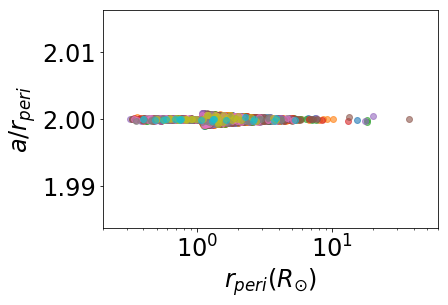

In [13]:
##check rperi and final sma of tidal capture binaries
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')
tcecc_init_emp, tcecc_finl_index, tcecc_des_emp = extract_key_index('ecc', index_tc_bin, 'bin')

tc_sma = tcsma_finl_index
tc_rperi = tcrperi_init_index
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#tc_sma = np.take(prop_finl['sma'], index_tc_bin)
#tc_ecc = np.take(prop_finl['ecc'], index_tc_bin)

plt.figure()
for i in range(len(paths)):
    ratio = np.array(tc_sma[i])*AU_Rsun/np.array(tc_rperi[i])
    plt.scatter(tc_rperi[i], ratio, alpha=0.6)
    
#plt.scatter(tc_rperi, tc_ecc)
plt.xlim(0.2, 60)
plt.xscale('log')
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$a/r_{peri}$')

Text(0,0.5,'$E_{orb}(M_\\odot \\cdot km/s^2)$')

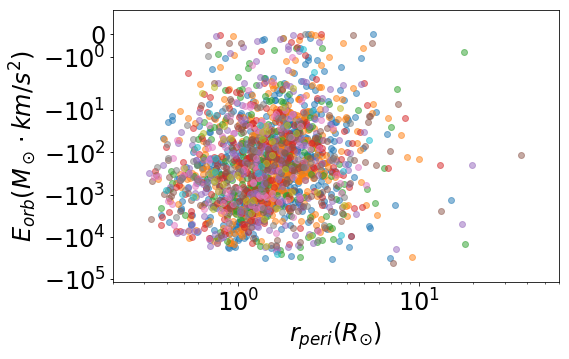

In [20]:
##check energy of tidal capture binaries
##Data from the fitting formulae
def Tl(order, polytropicindex, eta):
    l=order; n=polytropicindex; x=np.log10(eta); x2=x*x; x3=x*x2; x4=x2*x2; x5=x2*x3

    if l != 2 and l != 3:
        print("unknown order")
    
    ##From Portegies Zwart & Meinen 1993
    if n == 1.5:
        if l == 2: 
            return pow(10.0, -0.397 + 1.678*x + 1.277*x2 - 12.42*x3 + 9.446*x4 - 5.550*x5)
        else:
            return pow(10.0, -0.909 + 1.574*x + 12.37*x2 - 57.40*x3 + 80.10*x4 - 46.43*x5)
                
    elif n == 2.0:
        if l == 2:
            return pow(10.0, -0.517 - 0.906*x + 23.88*x2 - 93.49*x3 + 112.3*x4 - 44.15*x5)
        else:
            return pow(10.0, -1.040 - 1.354*x + 37.64*x2 - 139.9*x3 + 168.2*x4 - 66.53*x5)
                
    elif n == 3.0:
        if l == 2:
            return pow(10.0, -1.124 + 0.877*x - 13.37*x2 + 21.55*x3 - 16.48*x4 + 4.124*x5)
        else:
            return pow(10.0, -1.703 + 2.653*x - 14.34*x2 + 12.85*x3 - 0.492*x4 - 3.600*x5)
                
    else:
        printf("unknown polytropic index")
             
        

def E_oscillate(rperi, Mosc, Rosc, nosc, Mpert):
    eta=math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    #rperi = Rosc*pow((Mosc+Mpert)/Mosc,1/3)*pow(eta, 2/3)

    return Gconst_sun*PC_Rsun*Mpert**2/Rosc * (pow(Rosc/rperi, 6.0) * Tl(2, nosc, eta) + pow(Rosc/rperi, 8.0) * Tl(3, nosc, eta))
    
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
tcvinf_init_index, tcvinf_finl_emp, tcvinf_des_emp = extract_key_index('vinf', index_tc_bin, 'bin')
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')

tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index; tc_k0 = tck0_init_index
tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index; tc_k1 = tck1_init_index
tc_rperi = tcrperi_init_index; tc_vinf = tcvinf_init_index
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_r0 = np.take(prop_init['r0'], index_tc_bin)
#tc_r1 = np.take(prop_init['r1'], index_tc_bin)
#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#tc_vinf = np.take(prop_init['vinf'], index_tc_bin)

E_osc = []
for jj in range(len(paths)):
    E_osc.append([])
    for i in range(len(tc_m0[jj])):
        m_reduce = tc_m0[jj][i]*tc_m1[jj][i]/(tc_m0[jj][i]+tc_m1[jj][i])
        E_kin = 0.5*m_reduce*tc_vinf[jj][i]**2
        
        if tc_k0[jj][i]==1: n0 = 3.0
        elif tc_k0[jj][i]==0 or tc_k0[jj][i]==7: n0 = 1.5
        else: n0 = -100
        
        if tc_k1[jj][i]==1: n1 = 3.0
        elif tc_k1[jj][i]==0 or tc_k1[jj][i]==7: n1 = 1.5
        else: n1 = -100
    
        if n0!=-100 and n1!=-100:
            E0_osc = E_oscillate(tc_rperi[jj][i], tc_m0[jj][i], tc_r0[jj][i], n0, tc_m1[jj][i])
            E1_osc = E_oscillate(tc_rperi[jj][i], tc_m1[jj][i], tc_r1[jj][i], n1, tc_m0[jj][i])
            
            E_osc[jj].append(E_kin - E0_osc - E1_osc)
            
        elif n1==-100:
            E0_osc = E_oscillate(tc_rperi[jj][i], tc_m0[jj][i], tc_r0[jj][i], n0, tc_m1[jj][i])
            E_osc[jj].append(E_kin - E0_osc)
        
        elif n0==-100:
            E1_osc = E_oscillate(tc_rperi[jj][i], tc_m1[jj][i], tc_r1[jj][i], n1, tc_m0[jj][i])
            E_osc[jj].append(E_kin - E1_osc)
        else:
            print('Oops, something is wrong')
    
    
plt.figure(figsize = (8, 5))
for jj in range(len(paths)):
    plt.scatter(tc_rperi[jj], E_osc[jj], alpha=0.5)
plt.yscale('symlog')
plt.xscale('log')
plt.xlim(0.2, 60)
plt.ylim(ymax=1)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$E_{orb}(M_\odot \cdot km/s^2)$')

(0.2, 60)

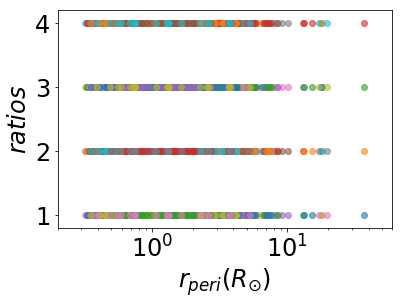

In [22]:
##Compare initial and final masses and radii of tidal capture binaries
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')

tc_m0_init = tcm0_init_index; tc_r0_init = tcr0_init_index
tc_m1_init = tcm1_init_index; tc_r1_init = tcr1_init_index
tc_m0_finl = tcm0_finl_index; tc_r0_finl = tcr0_finl_index
tc_m1_finl = tcm1_finl_index; tc_r1_finl = tcr1_finl_index
tc_rperi = tcrperi_init_index

#tc_m0_init = np.take(prop_init['m0'], index_tc_bin)
#tc_m1_init = np.take(prop_init['m1'], index_tc_bin)
#tc_r0_init = np.take(prop_init['r0'], index_tc_bin)
#tc_r1_init = np.take(prop_init['r1'], index_tc_bin)
#
#tc_m0_finl = np.take(prop_finl['m0'], index_tc_bin)
#tc_m1_finl = np.take(prop_finl['m1'], index_tc_bin)
#tc_r0_finl = np.take(prop_finl['r0'], index_tc_bin)
#tc_r1_finl = np.take(prop_finl['r1'], index_tc_bin)
#
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)

plt.figure()
for jj in range(len(paths)):
    ratio_m0 = np.array(tc_m0_finl[jj])/np.array(tc_m0_init[jj])
    ratio_m1 = np.array(tc_m1_finl[jj])/np.array(tc_m1_init[jj])
    ratio_r0 = np.array(tc_r0_finl[jj])/np.array(tc_r0_init[jj])
    ratio_r1 = np.array(tc_r1_finl[jj])/np.array(tc_r1_init[jj])

    plt.scatter(tc_rperi[jj], ratio_m0, alpha = 0.6)
    plt.scatter(tc_rperi[jj], ratio_m1+1, alpha = 0.6)
    plt.scatter(tc_rperi[jj], ratio_r0+2, alpha = 0.6)
    plt.scatter(tc_rperi[jj], ratio_r1+3, alpha = 0.6)
    
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$ratios$')
plt.xscale('log')
plt.xlim(0.2, 60)

In [24]:
##Check if the tidal capture binaries are mass transferring
def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl
    

tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')

tc_m0 = tcm0_finl_index; tc_r0 = tcr0_finl_index
tc_m1 = tcm1_finl_index; tc_r1 = tcr1_finl_index
tc_sma = tcsma_finl_index

#tc_m0 = np.take(prop_finl['m0'], index_tc_bin)
#tc_m1 = np.take(prop_finl['m1'], index_tc_bin)
#tc_r0 = np.take(prop_finl['r0'], index_tc_bin)
#tc_r1 = np.take(prop_finl['r1'], index_tc_bin)
#tc_sma = np.take(prop_finl['sma'], index_tc_bin)

for jj in range(len(paths)):
    for i in range(len(tc_m0[jj])):
        rl0 = rochradius(tc_m0[jj][i], tc_m1[jj][i], tc_sma[jj][i])
        rl1 = rochradius(tc_m1[jj][i], tc_m0[jj][i], tc_sma[jj][i])
        if rl0<=tc_r0[jj][i] or rl1<=tc_r1[jj][i]:
            print('Oops, something is wrong')

0 0
1 0
1 0
1 0
0 1
0 1
0 0
0 0
1 0
1 0
0 1
0 1
1 0
1 0
1 0
1 0
1 0
0 0
1 0
0 1
0 1
1 0
0 1
1 0
1 0
1 0
0 1
1 0
1 0
1 0
1 0
0 1
0 1
1 0
0 0
0 0
0 0
0 1
0 0
1 0
1 0
0 0
0 0
1 0
0 0
0 1
0 1
1 0
1 0
1 0
0 0
1 0
0 1
0 0
0 1
0 0
1 1
0 1
0 1
1 0
0 1
0 1
1 0
1 0
0 1
1 0
0 0
0 1
0 0
0 1
1 0
0 0
0 1
0 1
1 1
0 0
1 0
0 1
0 1
1 0
1 0
0 1
1 0
0 0
0 1
0 0
1 0
1 0
1 0
0 1
1 0
0 1
0 1
0 1
0 1
0 0
0 0
1 0
0 1
0 1
0 0
0 0
0 1
0 0
0 1
1 0
1 0
0 0
0 0
1 0
0 1
0 0
0 0
1 0
1 0
1 0
1 0
0 1
1 0
119


Text(0.5,0,'$\\eta$')

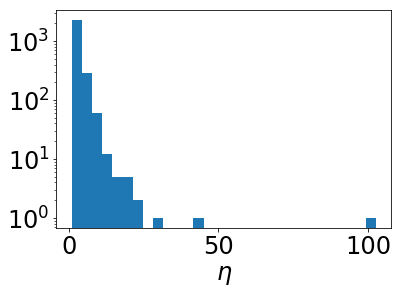

In [29]:
##Check eta for tidal capture process
def Eta(Mosc, Rosc, Mpert, rperi):
     return math.sqrt(Mosc/(Mosc+Mpert))*pow(rperi/Rosc, 1.5)
    
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')
  
tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index; tc_k0 = tck0_init_index
tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index; tc_k1 = tck1_init_index
tc_rperi = tcrperi_init_index
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_r0 = np.take(prop_init['r0'], index_tc_bin)
#tc_r1 = np.take(prop_init['r1'], index_tc_bin)
#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)

all_eta = []
n_eta = 0
for jj in range(len(paths)):
    for i in range(len(tc_k0[jj])):
        if tc_k0[jj][i]<=1 or tc_k0[jj][i]==7:
            all_eta.append(Eta(tc_m0[jj][i], tc_r0[jj][i], tc_m1[jj][i], tc_rperi[jj][i]))
            if Eta(tc_m0[jj][i], tc_r0[jj][i], tc_m1[jj][i], tc_rperi[jj][i])>7:
                n_eta+=1
                print(tc_k0[jj][i], tc_k1[jj][i])
                
        if tc_k1[jj][i]<=1 or tc_k1[jj][i]==7:
            all_eta.append(Eta(tc_m1[jj][i], tc_r1[jj][i], tc_m0[jj][i], tc_rperi[jj][i]))
            if Eta(tc_m1[jj][i], tc_r1[jj][i], tc_m0[jj][i], tc_rperi[jj][i])>7:
                n_eta+=1
                print(tc_k0[jj][i], tc_k1[jj][i])

print(n_eta)

plt.figure()
plt.
plt.hist(all_eta, bins=30)
plt.yscale('log')
plt.xlabel(r'$\eta$')

Text(0,0.5,'$ratios$')

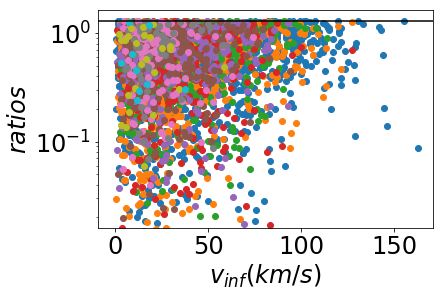

In [37]:
##Check the pericenter distance of all giant collision
collr0_init_index, collr0_finl_index, collr0_des_emp = extract_key_index('r0', index_coll_bin, 'bin')
collr1_init_index, collr1_finl_index, collr1_des_emp = extract_key_index('r1', index_coll_bin, 'bin')
collrperi_init_index, collrperi_finl_emp, collrperi_des_emp = extract_key_index('rperi', index_coll_bin, 'bin')
collvinf_init_index, collvinf_finl_emp, collvinf_des_emp = extract_key_index('vinf', index_coll_bin, 'bin')

collr0_init_emp, collr0_finl_emp, collr0_des_index = extract_key_index('r0', index_coll_des, 'des')
collr1_init_emp, collr1_finl_emp, collr1_des_index = extract_key_index('r1', index_coll_des, 'des')
collrperi_init_emp, collrperi_finl_emp, collrperi_des_index = extract_key_index('rperi', index_coll_des, 'des')
collvinf_init_emp, collvinf_finl_emp, collvinf_des_index = extract_key_index('vinf', index_coll_des, 'des')

#coll_r0_bin = np.take(prop_init['r0'], index_coll_bin)
#coll_r1_bin = np.take(prop_init['r1'], index_coll_bin)
#coll_rperi_bin = np.take(prop_init['rperi'], index_coll_bin)
#coll_vinf_bin = np.take(prop_init['vinf'], index_coll_bin)
#
#coll_r0_des = np.take(prop_des['r0'], index_coll_des)
#coll_r1_des = np.take(prop_des['r1'], index_coll_des)
#coll_rperi_des = np.take(prop_des['rperi'], index_coll_des)
#coll_vinf_des = np.take(prop_des['vinf'], index_coll_des)

#coll_r0 = np.concatenate((coll_r0_bin, coll_r0_des))
#coll_r1 = np.concatenate((coll_r1_bin, coll_r1_des))
#coll_rperi = np.concatenate((coll_rperi_bin, coll_rperi_des))
#coll_vinf = np.concatenate((coll_vinf_bin, coll_vinf_des))


plt.figure()
for jj in range(len(paths)):
    coll_rperi = np.array(collrperi_init_index[jj] + collrperi_des_index[jj])
    coll_r0 = np.array(collr0_init_index[jj] + collr0_des_index[jj])
    coll_r1 = np.array(collr1_init_index[jj] + collr1_des_index[jj])
    coll_vinf = np.array(collvinf_init_index[jj] + collvinf_des_index[jj])
    
    ratio = coll_rperi/(coll_r0+coll_r1)

    for i in range(len(ratio)):
        if ratio[i]>1.3:
            print(coll_r0[i], coll_r1[i])

    plt.scatter(coll_vinf, ratio)
    
plt.axhline(y=1.3, color = 'k')
plt.yscale('log')
plt.xlabel(r'$v_{inf}(km/s)$')
plt.ylabel(r'$ratios$')

Oops, something is wrong
0 5 0.609 5.7
0 8 0.609 1.84
0.876025364364442 1.4477624316667865 0.544213 4.29845
Oops, something is wrong
11 5 0.674 1.72
11 9 0.674 1.48
36.20864590557454 51.81412014309343 0.0118172 111.745
Oops, something is wrong
5 0 6.53 0.635
8 0 2.15 0.635
1.8507981601310608 1.0641202283962714 4.49345 0.571002
Oops, something is wrong
0 5 0.508 6.43
0 8 0.508 2.11
0.9496429502794189 1.8093970191498054 0.447305 10.777
Oops, something is wrong
5 0 4.34 0.631
8 0 1.35 0.631
1.3699040523452661 0.9686649163792154 29.8 0.567193
Oops, something is wrong
1 5 0.922 5.95
1 8 0.922 1.93
1.518646618452745 2.126553570292148 0.836469 6.87017
Oops, something is wrong
5 1 5.69 1.65
8 1 1.83 1.65
2.9641044983790263 2.8271459065399163 3.71248 1.05535
Oops, something is wrong
1 5 0.737 5.34
1 8 0.737 1.7
0.7527747161051677 1.1014906873716455 0.675378 1.2456


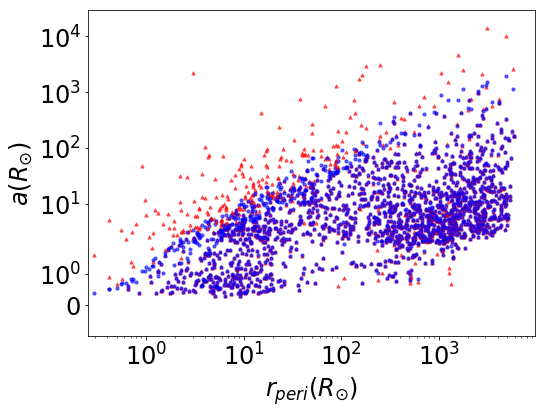

In [15]:
##Check the CE outcomes of giant-giant collisions and RLOF

def coll_CE(Mrg, Mint, Mwd, Rrg, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    ##a_f in unit of solar radius
    return(1.0/(2.0*Mrg*(Mrg-Mwd)/(Mwd*Mint*alpha1*lambdaf*Rrg)-(Mrg+Mint)/(Gconst_sun*PC_Rsun*Mwd*Mint*alpha1)*vinf*vinf))


def coll_CE_twogiants(M1, M2, Mc1, Mc2, R1, R2, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    E_bindi = Gconst_sun*PC_Rsun/lambdaf*(M1*(M1-Mc1)/R1+M2*(M2-Mc2)/R2)
    E_orbi = 0.5*(M1+M2)*vinf*vinf

    af = Gconst_sun*PC_Rsun*Mc1*Mc2*alpha1/(2*(E_bindi-E_orbi))

    return af

def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl


collm0_init_index, collm0_finl_index, collm0_des_emp = extract_key_index('m0', index_coll_bin, 'bin')
collm1_init_index, collm1_finl_index, collm1_des_emp = extract_key_index('m1', index_coll_bin, 'bin')
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')
collr0_init_index, collr0_finl_index, collr0_des_emp = extract_key_index('r0', index_coll_bin, 'bin')
collr1_init_index, collr1_finl_index, collr1_des_emp = extract_key_index('r1', index_coll_bin, 'bin')
collrperi_init_index, collrperi_finl_emp, collrperi_des_emp = extract_key_index('rperi', index_coll_bin, 'bin')
collvinf_init_index, collvinf_finl_emp, collvinf_des_emp = extract_key_index('vinf', index_coll_bin, 'bin')
collsma_init_emp, collsma_finl_index, collsma_des_emp = extract_key_index('sma', index_coll_bin, 'bin')

#coll_m0_init = np.take(prop_init['m0'], index_coll_bin)
#coll_m1_init = np.take(prop_init['m1'], index_coll_bin)
#coll_r0_init = np.take(prop_init['r0'], index_coll_bin)
#coll_r1_init = np.take(prop_init['r1'], index_coll_bin)
#coll_k0_init = np.take(prop_init['k0'], index_coll_bin)
#coll_k1_init = np.take(prop_init['k1'], index_coll_bin)

#coll_m0_finl = np.take(prop_finl['m0'], index_coll_bin)
#coll_m1_finl = np.take(prop_finl['m1'], index_coll_bin)
#coll_r0_finl = np.take(prop_finl['r0'], index_coll_bin)
#coll_r1_finl = np.take(prop_finl['r1'], index_coll_bin)

#coll_vinf = np.take(prop_init['vinf'], index_coll_bin)
#coll_sma = np.take(prop_finl['sma'], index_coll_bin)*AU_Rsun
#coll_rperi = np.take(prop_init['rperi'], index_coll_bin)

coll_k0_init = collk0_init_index; coll_m0_init = collm0_init_index; coll_r0_init = collr0_init_index
coll_k1_init = collk1_init_index; coll_m1_init = collm1_init_index; coll_r1_init = collr1_init_index
coll_k0_finl = collk0_finl_index; coll_m0_finl = collm0_finl_index; coll_r0_finl = collr0_finl_index
coll_k1_finl = collk1_finl_index; coll_m1_finl = collm1_finl_index; coll_r1_finl = collr1_finl_index
coll_vinf = collvinf_init_index; coll_rperi = collrperi_init_index
coll_sma = collsma_finl_index


plt.figure(figsize=(8, 6))
for jj in range(len(paths)):
    ce_af = []
    for i in range(len(coll_k0_init[jj])):
        if (2<=coll_k0_init[jj][i]<=9 and coll_k0_init[jj][i]!=7) and (2<=coll_k1_init[jj][i]<=9 and coll_k1_init[jj][i]!=7):
            af_temp = coll_CE_twogiants(coll_m0_init[jj][i], coll_m1_init[jj][i], coll_m0_finl[jj][i], coll_m1_finl[jj][i],
                                       coll_r0_init[jj][i], coll_r1_init[jj][i], coll_vinf[jj][i])
            ce_af.append(af_temp)
        elif 2<=coll_k0_init[jj][i]<=9 and coll_k0_init[jj][i]!=7:
            af_temp = coll_CE(coll_m0_init[jj][i], coll_m1_init[jj][i], coll_m0_finl[jj][i], coll_r0_init[jj][i], coll_vinf[jj][i])
            ce_af.append(af_temp)
        elif 2<=coll_k1_init[jj][i]<=9 and coll_k1_init[jj][i]!=7:
            af_temp = coll_CE(coll_m1_init[jj][i], coll_m0_init[jj][i], coll_m1_finl[jj][i], coll_r1_init[jj][i], coll_vinf[jj][i])
            ce_af.append(af_temp)
        
    plt.scatter(coll_rperi[jj], ce_af, s = 10, color = 'red', marker = '^', alpha=0.6)
    plt.scatter(coll_rperi[jj], np.array(coll_sma[jj])*AU_Rsun, s = 10, color = 'blue', alpha=0.6)
    
plt.yscale('symlog')
plt.xscale('log')
plt.ylim(-1, 30000)
plt.xlabel(r'$r_{peri}(R_{\odot})$')
plt.ylabel(r'$a(R_{\odot})$')
#plt.legend(loc='best', fontsize=12)

#ratio = coll_sma/(coll_r0_finl+coll_r1_finl)
#plt.figure()
#plt.scatter(coll_rperi, ratio)
#plt.yscale('log')
#plt.xscale('log')
#print(np.min(coll_sma)*AU_Rsun, np.min(ratio))

for kk in range(len(paths)):
    for i in range(len(coll_m0_finl[kk])):
        rl0 = rochradius(coll_m0_finl[kk][i], coll_m1_finl[kk][i], coll_sma[kk][i])
        rl1 = rochradius(coll_m1_finl[kk][i], coll_m0_finl[kk][i], coll_sma[kk][i])
        if rl0<=coll_r0_finl[kk][i] or rl1<=coll_r1_finl[kk][i]:
            print('Oops, something is wrong')
            print(coll_k0_init[kk][i], coll_k1_init[kk][i], coll_m0_init[kk][i], coll_m1_init[kk][i])
            print(coll_k0_finl[kk][i], coll_k1_finl[kk][i], coll_m0_finl[kk][i], coll_m1_finl[kk][i])
            print(rl0, rl1, coll_r0_finl[kk][i], coll_r1_finl[kk][i])
            

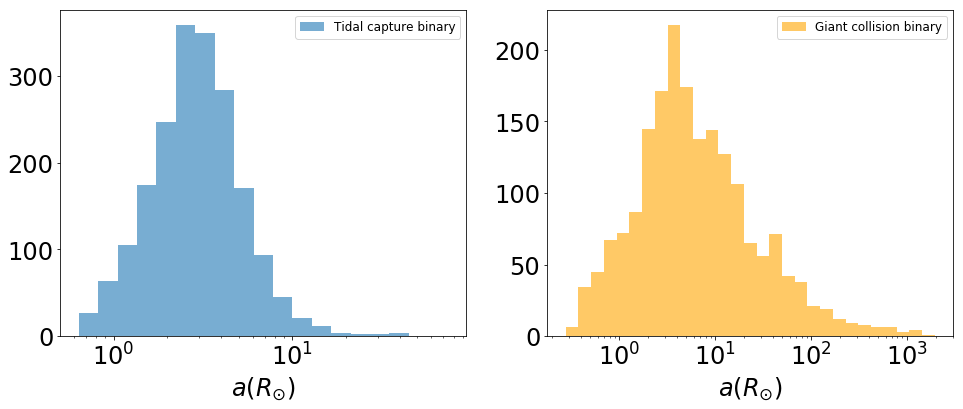

In [17]:
##Plot the distribution of SMA
collsma_init_emp, collsma_finl_index, collsma_des_emp = extract_key_index('sma', index_coll_bin, 'bin')
collrperi_init_index, collrperi_finl_emp, collrperi_des_emp = extract_key_index('rperi', index_coll_bin, 'bin')
tcsma_init_emp, tcsma_finl_index, tcsma_des_emp = extract_key_index('sma', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')

#tc_sma = np.take(prop_finl['sma'], index_tc_bin)*AU_Rsun
#coll_sma = np.take(prop_finl['sma'], index_coll_bin)*AU_Rsun
#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#coll_rperi = np.take(prop_init['rperi'], index_coll_bin)
tc_sma = []; coll_sma = []
for jj in range(len(paths)):
    tc_sma = tc_sma + [x*AU_Rsun for x in tcsma_finl_index[jj]]
    coll_sma = coll_sma + [y*AU_Rsun for y in collsma_finl_index[jj]]
    

fig, axs = plt.subplots(ncols = 2, figsize=(16, 6))
axs[0].hist(tc_sma, bins=np.logspace(np.log10(min(tc_sma)), np.log10(max(tc_sma)), 20), alpha=0.6, label = 'Tidal capture binary')
#axs[0].hist(tc_rperi, bins=np.logspace(np.log10(min(tc_rperi)), np.log10(max(tc_rperi)), 20), alpha=0.6)

axs[0].set_xscale('log')
axs[0].locator_params(axis='x', numticks = 6)
axs[0].set_xlabel(r'$a(R_{\odot})$')
axs[0].legend(loc='best', fontsize = 12)

axs[1].hist(coll_sma, bins=np.logspace(np.log10(min(coll_sma)), np.log10(max(coll_sma)), 30), color = 'orange', alpha=0.6, label = 'Giant collision binary')
axs[1].set_xscale('log')
axs[1].locator_params(axis='x', numticks = 6)
axs[1].set_xlabel(r'$a(R_{\odot})$')
axs[1].legend(loc='best', fontsize = 12)


In [3]:
##Check the hardness of tidal capture binaries
tc_hardness = []; coll_hardness = []
tc_length_ratio = []; coll_length_ratio = []

mave = 1.; v_sigma = 10. ##mave in solar unit, v_sigma in km/s
kt = mave*v_sigma**2

nloc = 10000.   ##pc^-3
length_factor = 0.1
lloc = length_factor*nloc**(-1/3)*PC_AU

for jj in range(len(paths)):
    for i in range(len(index_tc_bin[jj])):
        number_tc = int(index_tc_bin[jj][i])
        ebind_temp = Gconst_sun*prop_finl[str(jj)]['m0'][number_tc]*prop_finl[str(jj)]['m1'][number_tc]/(prop_finl[str(jj)]['sma'][number_tc]/PC_AU)
        tc_hardness.append(ebind_temp/kt)   
        tc_length_ratio.append(prop_finl[str(jj)]['sma'][number_tc]/lloc)


    for j in range(len(index_coll_bin[jj])):
        number_coll = int(index_coll_bin[jj][j])
        ebind_temp = Gconst_sun*prop_finl[str(jj)]['m0'][number_coll]*prop_finl[str(jj)]['m1'][number_coll]/(prop_finl[str(jj)]['sma'][number_coll]/PC_AU)
        coll_hardness.append(ebind_temp/kt)
        coll_length_ratio.append(prop_finl[str(jj)]['sma'][number_coll]/lloc)
    

    #print(tc_hardness, coll_hardness)
    print(jj, np.mean(tc_hardness), np.mean(coll_hardness))
    #print(tc_length_ratio, coll_length_ratio)
    print(jj, np.mean(tc_length_ratio), np.mean(coll_length_ratio))

0 938.0730137159466 1283.7004404120826
0 1.6987289218845452e-05 9.970158632804648e-05
1 904.4388493512811 1299.2077514811658
1 1.7313936975696146e-05 0.00011695131965737338
2 984.7379035900054 1406.5507095302235
2 1.7377220164063894e-05 0.00012541484491373003
3 992.3762582512046 1437.1930467977782
3 1.7155445762760177e-05 0.00013305746328115322
4 1026.674420217272 1479.4675597899532
4 1.717424969606201e-05 0.00013104129362959447
5 1063.4966132401323 1502.4968928347382
5 1.7524898005115324e-05 0.00013099432276313742
6 1054.0676181359445 1503.3227332095137
6 1.7333209385911626e-05 0.00012976536797252713
7 1054.0158890359935 1507.3393255517046
7 1.7205995221013648e-05 0.00013196854645631696
8 1052.2348491836292 1503.1867545904126
8 1.713142277932947e-05 0.00013162483172266359
9 1055.9315644951246 1502.9449771846482
9 1.7123501962026654e-05 0.00013144727798823842


0 385252 1611312
1 1334788 27646


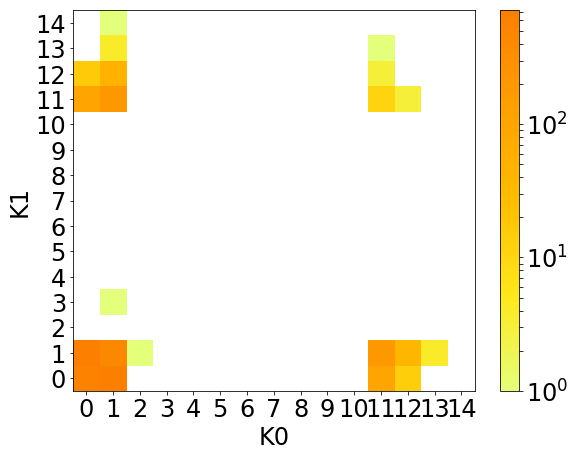

In [6]:
##Check sticky sphere collisions
K0 = []; K1 = []
for jj in range(len(paths)):
    sticky_k0 = np.take(all_sscoll[str(jj)]['k0'], index_sticky[jj])
    sticky_k1 = np.take(all_sscoll[str(jj)]['k1'], index_sticky[jj])
    sticky_id0 = np.take(all_sscoll[str(jj)]['id0'], index_sticky[jj])
    sticky_id1 = np.take(all_sscoll[str(jj)]['id1'], index_sticky[jj])

    K0=K0 + [x - 0.5 for x in sticky_k0]
    K1=K1 + [Y - 0.5 for Y in sticky_k1]
    
    for i in range(len(sticky_k0)):
        if 2<=sticky_k0[i]<=9 or 2<=sticky_k1[i]<=9:
            print(jj, sticky_id0[i], sticky_id1[i])
    
plt.figure(figsize = (9, 7))
ax=plt.gca()
plt.hist2d(K0, K1, bins=np.arange(16)-0.5, norm=mpl.colors.LogNorm(), cmap='Wistia')
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.yaxis.set_major_locator(plt.MaxNLocator(15))
plt.xlabel('K0')
plt.ylabel('K1')
plt.colorbar()

In [9]:
##Check tidal capture that leads to tidal disruption
def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl
    

for jj in range(len(paths)):    
    tde_m0 = np.take(all_sscoll[str(jj)]['m0'], index_tde[jj])
    tde_m1 = np.take(all_sscoll[str(jj)]['m1'], index_tde[jj])
    tde_r0 = np.take(all_sscoll[str(jj)]['r0'], index_tde[jj])
    tde_r1 = np.take(all_sscoll[str(jj)]['r1'], index_tde[jj])
    tde_k0 = np.take(all_sscoll[str(jj)]['k0'], index_tde[jj])
    tde_k1 = np.take(all_sscoll[str(jj)]['k1'], index_tde[jj])
    tde_id0 = np.take(all_sscoll[str(jj)]['id0'], index_tde[jj])
    tde_id1 = np.take(all_sscoll[str(jj)]['id1'], index_tde[jj])
    tde_sma = np.take(all_sscoll[str(jj)]['rperi'], index_tde[jj])*2./AU_Rsun

    #print(tde_k0, tde_k1)
    #print(tde_id0, tde_id1)

    for i in range(len(tde_m0)):
        rl0 = rochradius(tde_m0[i], tde_m1[i], tde_sma[i])
        rl1 = rochradius(tde_m1[i], tde_m0[i], tde_sma[i])
        if rl1>=tde_r1[i] and rl0>=tde_r0[i]:
            print('Oops, something is wrong')

In [3]:
##Check giant-giant collision that lead to merger
def coll_CE(Mrg, Mint, Mwd, Rrg, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    ##a_f in unit of solar radius
    return 1.0/(2.0*Mrg*(Mrg-Mwd)/(Mwd*Mint*alpha1*lambdaf*Rrg)-(Mrg+Mint)/(Gconst_sun*PC_Rsun*Mwd*Mint*alpha1)*vinf*vinf)


def coll_CE_twogiants(M1, M2, Mc1, Mc2, R1, R2, vinf):
    alpha1 = 1.0
    lambdaf = 0.5

    E_bindi = Gconst_sun*PC_Rsun/lambdaf*(M1*(M1-Mc1)/R1+M2*(M2-Mc2)/R2)
    E_orbi = 0.5*(M1+M2)*vinf*vinf

    af = Gconst_sun*PC_Rsun*Mc1*Mc2*alpha1/(2*(E_bindi-E_orbi))

    return af

def rochradius(m0, m1, sma):  ##sma is in AU, rl is in Rsun
    q = m0/m1   
    p = pow(q, 1.0/3.0)
    rl = 0.49*p*p/(0.6*p*p+math.log(1.0+p))*sma*AU_Rsun
    return rl


for jj in range(len(paths)):
    #gmerge_m0 = np.take(all_sscoll[str(jj)]['m0'], index_gmerge[jj])
    #gmerge_m1 = np.take(all_sscoll[str(jj)]['m1'], index_gmerge[jj])
    #gmerge_r0 = np.take(all_sscoll[str(jj)]['r0'], index_gmerge[jj])
    #gmerge_r1 = np.take(all_sscoll[str(jj)]['r1'], index_gmerge[jj])
    #gmerge_k0 = np.take(all_sscoll[str(jj)]['k0'], index_gmerge[jj])
    #gmerge_k1 = np.take(all_sscoll[str(jj)]['k1'], index_gmerge[jj])
    #gmerge_id0 = np.take(all_sscoll[str(jj)]['id0'], index_gmerge[jj])
    #gmerge_id1 = np.take(all_sscoll[str(jj)]['id1'], index_gmerge[jj])
    
    coll_m0_des = np.take(prop_des[str(jj)]['m0'], index_coll_des[jj])
    coll_m1_des = np.take(prop_des[str(jj)]['m1'], index_coll_des[jj])
    coll_mc0_des = prop_des[str(jj)]['mc0']
    coll_mc1_des = prop_des[str(jj)]['mc1']
    
    coll_r0_des = np.take(prop_des[str(jj)]['r0'], index_coll_des[jj])
    coll_r1_des = np.take(prop_des[str(jj)]['r1'], index_coll_des[jj])
    coll_rc0_des = prop_des[str(jj)]['rc0']
    coll_rc1_des = prop_des[str(jj)]['rc1']
    
    coll_k0_des = np.take(prop_des[str(jj)]['k0'], index_coll_des[jj])
    coll_k1_des = np.take(prop_des[str(jj)]['k1'], index_coll_des[jj])
    coll_id0_des = np.take(prop_des[str(jj)]['id0'], index_coll_des[jj])
    coll_id1_des = np.take(prop_des[str(jj)]['id1'], index_coll_des[jj])
    coll_vinf_des = np.take(prop_des[str(jj)]['vinf'], index_coll_des[jj])
    coll_rperi_des = np.take(prop_des[str(jj)]['rperi'], index_coll_des[jj])

    #print(gmerge_id0-coll_id0_des)
    
    ce_af = []
    for i in range(len(coll_k0_des)):
        if (2<=coll_k0_des[i]<=9 and coll_k0_des[i]!=7) and (2<=coll_k1_des[i]<=9 and coll_k1_des[i]!=7):
            ace_temp = coll_CE_twogiants(coll_m0_des[i], coll_m1_des[i], coll_mc0_des[i], coll_mc1_des[i],coll_r0_des[i], coll_r1_des[i], coll_vinf_des[i])
            ce_af.append(ace_temp)
            
            rl0 = rochradius(coll_mc0_des[i], coll_mc1_des[i], ace_temp/AU_Rsun)
            rl1 = rochradius(coll_mc1_des[i], coll_mc0_des[i], ace_temp/AU_Rsun)
            if rl1>=coll_rc1_des[i] and rl0>=coll_rc0_des[i] :
                print('Oops, something is wrong', jj, ace_temp, rl0, rl1, coll_rc0_des[i], coll_rc1_des[i], coll_rperi_des[i], 
                      coll_k0_des[i], coll_k1_des[i], coll_id0_des[i], coll_id1_des[i])
            
        elif 2<=coll_k0_des[i]<=9 and coll_k0_des[i]!=7:
            ecoll = 0.88 - coll_rperi_des[i]/(3.0*coll_r0_des[i])
            acoll = coll_rperi_des[i]/(3.3*(1.0-ecoll*ecoll))
            
            ace_temp = coll_CE(coll_m0_des[i], coll_m1_des[i], coll_mc0_des[i], coll_r0_des[i], coll_vinf_des[i])
            
            if acoll<=ace_temp:
                af_temp = acoll
            else:
                af_temp = ace_temp
            
            ce_af.append(af_temp)
            
            rl0 = rochradius(coll_mc0_des[i], coll_m1_des[i], af_temp/AU_Rsun)
            rl1 = rochradius(coll_m1_des[i], coll_mc0_des[i], af_temp/AU_Rsun)
            if rl1>=coll_r1_des[i] and rl0>=coll_rc0_des[i]:
                print('Oops, something is wrong', jj, af_temp, rl0, rl1, coll_rc0_des[i], coll_r1_des[i], coll_rperi_des[i], 
                      coll_k0_des[i], coll_k1_des[i], coll_id0_des[i], coll_id1_des[i])
                print(ace_temp, acoll)
                
        elif 2<=coll_k1_des[i]<=9 and coll_k1_des[i]!=7:
            ecoll = 0.88 - coll_rperi_des[i]/(3.0*coll_r1_des[i])
            acoll = coll_rperi_des[i]/(3.3*(1.0-ecoll*ecoll))
            
            ace_temp = coll_CE(coll_m1_des[i], coll_m0_des[i], coll_mc1_des[i], coll_r1_des[i], coll_vinf_des[i])
            
            if acoll<=ace_temp:
                af_temp = acoll
            else:
                af_temp = ace_temp
            
            ce_af.append(af_temp)  
            
            rl0 = rochradius(coll_m0_des[i], coll_mc1_des[i], af_temp/AU_Rsun)
            rl1 = rochradius(coll_mc1_des[i], coll_m0_des[i], af_temp/AU_Rsun)
            if rl1>=coll_rc1_des[i] and rl0>=coll_r0_des[i]:
                print('Oops, something is wrong', jj, af_temp, rl0, rl1, coll_r0_des[i], coll_rc1_des[i], coll_rperi_des[i], 
                      coll_k0_des[i], coll_k1_des[i], coll_id0_des[i], coll_id1_des[i])
                print(ace_temp, acoll)
    print(len(coll_k0_des))

#Something is wrong but I don't know why!

Oops, something is wrong 0 3.154879535431226 2.373937686735278 0.24304697865058136 2.37129 0.210281 143.29 4 0 515730 360038
3.154879535431226 174.53861720584104
934
Oops, something is wrong 1 2.0322068649346017 0.2597477633529007 1.3927223143398226 0.258032 1.15346 1409.85 0 4 315587 149405
2.0322068649346017 562.2033906636289
562
282
256
202
165
71
33
18
5


0 1 1 0.705 5.63 0.643295 2.09038
0 1 0 16.7 0.231 6.33671 0.243109
0 1 0 11.0 0.197 4.54174 0.215196
0 14 1 40.5 21.1 0.00017172 5.63605
0 0 1 0.421 5.3 0.376987 2.36443
0 14 1 40.5 5.91 0.00017172 2.81153
1 1 0 47.0 0.517 8.50559 0.455206
1 0 1 0.564 32.4 0.499693 7.32622
1 0 1 0.226 16.9 0.239026 6.57839
1 1 0 9.66 0.16 3.8132 0.181828
1 1 14 7.91 40.5 4.09784 0.00017172
1 1 0 6.43 0.509 3.08788 0.448272
1 1 0 5.04 0.26 2.57824 0.264204
2 0 1 0.547 25.6 0.483549 5.75484
2 1 1 11.8 63.1 3.41654 13.5811
2 1 0 24.7 0.121 12.8325 0.138592
2 1 1 6.52 1.94 3.53583 1.12178
3 1 1 0.932 39.4 0.843059 10.8633
3 0 1 0.162 7.68 0.183504 2.67555
4 1 1 43.3 14.2 10.2589 3.95255
4 1 1 40.7 5.41 14.9558 2.05624
4 1 0 8.19 0.17 3.31532 0.191041
4 1 0 7.77 0.513 3.51188 0.452211
4 14 1 23.7 6.82 0.000100601 3.55418
5 1 0 14.1 0.291 3.80201 0.285807
5 1 0 85.8 0.641 36.2193 0.577031
5 0 1 0.283 13.5 0.280753 4.1915
5 14 1 38.6 7.25 0.000163839 4.78997
5 1 14 5.63 20.5 3.8739 8.71083e-05


Text(0.5,0.98,'Tidal Capture')

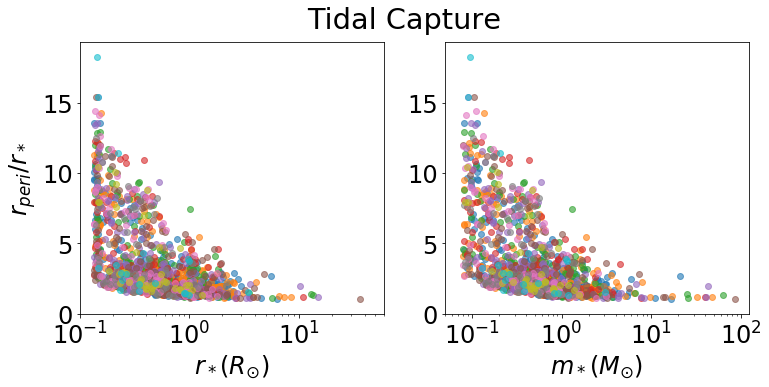

In [7]:
# M-Rperi relation of tidal capture
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tcr0_init_index, tcr0_finl_index, tcr0_des_emp = extract_key_index('r0', index_tc_bin, 'bin')
tcr1_init_index, tcr1_finl_index, tcr1_des_emp = extract_key_index('r1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
tcrperi_init_index, tcrperi_finl_emp, tcrperi_des_emp = extract_key_index('rperi', index_tc_bin, 'bin')

#tc_rperi = np.take(prop_init['rperi'], index_tc_bin)
#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_r0 = np.take(prop_init['r0'], index_tc_bin)
#tc_r1 = np.take(prop_init['r1'], index_tc_bin)

tc_rperi = tcrperi_init_index
tc_k0 = tck0_init_index; tc_m0 = tcm0_init_index; tc_r0 = tcr0_init_index
tc_k1 = tck1_init_index; tc_m1 = tcm1_init_index; tc_r1 = tcr1_init_index


fig, axs = plt.subplots(ncols=2, figsize = (12, 5))
for jj in range(len(paths)):
    rstar = []; mstar = []
    for i in range(len(tc_k0[jj])):
        if tc_k0[jj][i] < 10 and tc_k1[jj][i] < 10:
            rstar.append(max(tc_r0[jj][i], tc_r1[jj][i]))
            mstar.append(max(tc_m0[jj][i], tc_m1[jj][i]))
            
        elif tc_k0[jj][i] < 10:
            rstar.append(tc_r0[jj][i]); mstar.append(tc_m0[jj][i])
            
        elif tc_k1[jj][i] < 10:
            rstar.append(tc_r1[jj][i]); mstar.append(tc_m1[jj][i])
        
        else:
            print("What's going on?")
        
        if (tc_k0[jj][i]<=1 and tc_m0[jj][i]>=5) or (tc_k1[jj][i]<=1 and tc_m1[jj][i]>=5):
            print(jj, tc_k0[jj][i], tc_k1[jj][i], tc_m0[jj][i], tc_m1[jj][i], tc_r0[jj][i], tc_r1[jj][i])
            
    rstar = np.array(rstar); mstar = np.array(mstar)    
    axs[0].scatter(rstar, tc_rperi[jj]/rstar, alpha=0.6)
    axs[1].scatter(mstar, tc_rperi[jj]/rstar, alpha=0.6)

axs[0].set_xlim(0.1, 60)
axs[0].set_ylabel(r'$r_{peri}/r_*$')
axs[0].set_xlabel(r'$r_* (R_{\odot})$')
#axs[1].set_ylabel(r'$r_{peri}/r_*$')
axs[1].set_xlabel(r'$m_* (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

plt.suptitle('Tidal Capture')

666 662 1328
691 389 1080
1206 1196 1074
1237 707 864
1424 1414 436
1507 827 390
1592 1582 336
1812 964 442
1719 1709 254
2077 1085 386
1822 1812 206
2299 1179 316
1861 1851 78
2441 1235 198
1889 1879 56
2538 1268 130
1896 1886 14
2601 1283 78
1900 1890 8
2631 1291 38


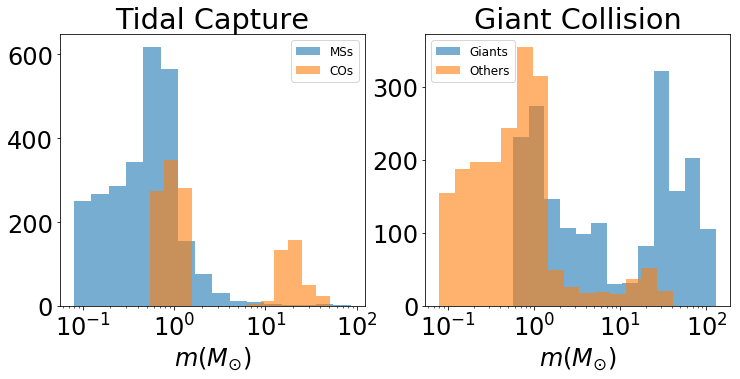

In [5]:
##Mass distribution of giant collision and tidal capture
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
collm0_init_index, collm0_finl_index, collm0_des_emp = extract_key_index('m0', index_coll_bin, 'bin')
collm1_init_index, collm1_finl_index, collm1_des_emp = extract_key_index('m1', index_coll_bin, 'bin')
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')

tc_k0 = tck0_init_index; tc_m0 = tcm0_init_index
tc_k1 = tck1_init_index; tc_m1 = tcm1_init_index
coll_k0 = collk0_init_index; coll_m0 = collm0_init_index
coll_k1 = collk1_init_index; coll_m1 = collm1_init_index

#tc_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_k1 = np.take(prop_init['k1'], index_tc_bin)
#tc_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_m1 = np.take(prop_init['m1'], index_tc_bin)
#coll_m0 = np.take(prop_init['m0'], index_coll_bin)
#coll_m1 = np.take(prop_init['m1'], index_coll_bin)
#coll_k0 = np.take(prop_init['k0'], index_coll_bin)
#coll_k1 = np.take(prop_init['k1'], index_coll_bin)

tc_msm = []; tc_com = []
coll_giantm = []; coll_otherm = []
for jj in range(len(paths)):
    tc_totm = tc_m0[jj]+tc_m1[jj]
    coll_totm = coll_m0[jj]+coll_m1[jj]
    
    for i in range(len(coll_k0[jj])):
        if 2<=coll_k0[jj][i]<=9 and coll_k0[jj][i]!=7:
            coll_giantm.append(coll_m0[jj][i])
        else:
            coll_otherm.append(coll_m0[jj][i])
        
        if 2<=coll_k1[jj][i]<=9 and coll_k1[jj][i]!=7:
            coll_giantm.append(coll_m1[jj][i])
        else:
            coll_otherm.append(coll_m1[jj][i])
    print(len(coll_giantm), len(coll_otherm), len(coll_totm))
    
    
    for i in range(len(tc_k0[jj])):
        if tc_k0[jj][i] <= 1 or tc_k0[jj][i] == 7:
            tc_msm.append(tc_m0[jj][i])
        else:
            tc_com.append(tc_m0[jj][i])
            
        if tc_k1[jj][i] <= 1 or tc_k1[jj][i] == 7:
            tc_msm.append(tc_m1[jj][i])
        else:
            tc_com.append(tc_m1[jj][i])
            
    print(len(tc_msm), len(tc_com), len(tc_totm))

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
#axs[0].hist(tc_totm, bins = np.logspace(np.log10(min(tc_totm)), np.log10(max(tc_totm)), 20), label = 'Tidal Capture', alpha=0.6)
#axs[1].hist(coll_totm, bins = np.logspace(np.log10(min(coll_totm)), np.log10(max(coll_totm)), 20), histtype= 'step', color = 'k', lw = 4, alpha=0.6)
axs[0].hist(tc_msm, bins = np.logspace(np.log10(min(tc_msm)), np.log10(max(tc_msm)), 17), alpha=0.6, label = 'MSs')
axs[0].hist(tc_com, bins = np.logspace(np.log10(min(tc_com)), np.log10(max(tc_com)), 15), alpha=0.6, label = 'COs')

axs[1].hist(coll_giantm, bins = np.logspace(np.log10(min(coll_giantm)), np.log10(max(coll_giantm)), 14), alpha=0.6, label = 'Giants')
axs[1].hist(coll_otherm, bins = np.logspace(np.log10(min(coll_otherm)), np.log10(max(coll_otherm)), 16), alpha=0.6, label = 'Others')


axs[0].set_xlabel(r'$m (M_{\odot})$')
axs[1].set_xlabel(r'$m (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].legend(loc='best', fontsize=12)
axs[1].legend(loc='best', fontsize=12)


1611 1585 3196
812 510 1322
2721 2673 2198
1466 936 1080
3223 3171 1000
1771 1091 460
3651 3591 848
2101 1253 492
3982 3918 658
2391 1399 436
4251 4185 536
2634 1514 358
4361 4295 220
2780 1574 206
4422 4356 122
2881 1611 138
4447 4381 50
2948 1630 86
4456 4390 18
2978 1638 38


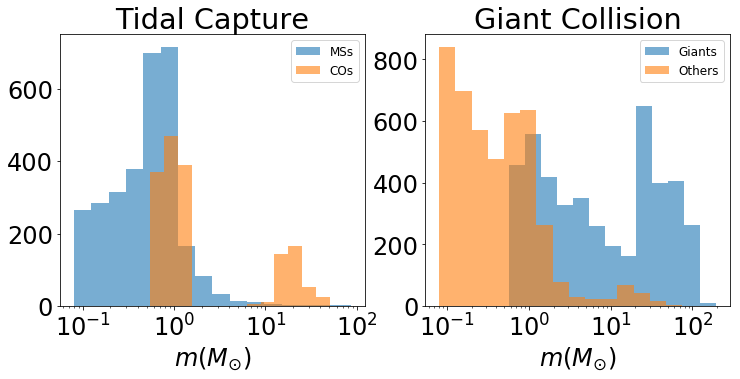

In [5]:
##All mass distribution of giant collision and tidal capture (including merging systems)
tcm0_init_index, tcm0_finl_index, tcm0_des_emp = extract_key_index('m0', index_tc_bin, 'bin')
tcm1_init_index, tcm1_finl_index, tcm1_des_emp = extract_key_index('m1', index_tc_bin, 'bin')
tck0_init_index, tck0_finl_index, tck0_des_emp = extract_key_index('k0', index_tc_bin, 'bin')
tck1_init_index, tck1_finl_index, tck1_des_emp = extract_key_index('k1', index_tc_bin, 'bin')
collm0_init_index, collm0_finl_index, collm0_des_emp = extract_key_index('m0', index_coll_bin, 'bin')
collm1_init_index, collm1_finl_index, collm1_des_emp = extract_key_index('m1', index_coll_bin, 'bin')
collk0_init_index, collk0_finl_index, collk0_des_emp = extract_key_index('k0', index_coll_bin, 'bin')
collk1_init_index, collk1_finl_index, collk1_des_emp = extract_key_index('k1', index_coll_bin, 'bin')

tc_k0 = tck0_init_index; tc_m0 = tcm0_init_index
tc_k1 = tck1_init_index; tc_m1 = tcm1_init_index
coll_k0 = collk0_init_index; coll_m0 = collm0_init_index
coll_k1 = collk1_init_index; coll_m1 = collm1_init_index

tcm0_init_emp, tcm0_finl_emp, tcm0_des_index = extract_key_index('m0', index_tc_des, 'des')
tcm1_init_emp, tcm1_finl_emp, tcm1_des_index = extract_key_index('m1', index_tc_des, 'des')
tck0_init_emp, tck0_finl_emp, tck0_des_index = extract_key_index('k0', index_tc_des, 'des')
tck1_init_emp, tck1_finl_emp, tck1_des_index = extract_key_index('k1', index_tc_des, 'des')
collm0_init_emp, collm0_finl_emp, collm0_des_index = extract_key_index('m0', index_coll_des, 'des')
collm1_init_emp, collm1_finl_emp, collm1_des_index = extract_key_index('m1', index_coll_des, 'des')
collk0_init_emp, collk0_finl_emp, collk0_des_index = extract_key_index('k0', index_coll_des, 'des')
collk1_init_emp, collk1_finl_emp, collk1_des_index = extract_key_index('k1', index_coll_des, 'des')

tc_k0_des = tck0_des_index; tc_m0_des = tcm0_des_index
tc_k1_des = tck1_des_index; tc_m1_des = tcm1_des_index
coll_k0_des = collk0_des_index; coll_m0_des = collm0_des_index
coll_k1_des = collk1_des_index; coll_m1_des = collm1_des_index

#tc_bin_m0 = np.take(prop_init['m0'], index_tc_bin)
#tc_bin_m1 = np.take(prop_init['m1'], index_tc_bin)
#tc_bin_k0 = np.take(prop_init['k0'], index_tc_bin)
#tc_bin_k1 = np.take(prop_init['k1'], index_tc_bin)
#coll_bin_m0 = np.take(prop_init['m0'], index_coll_bin)
#coll_bin_m1 = np.take(prop_init['m1'], index_coll_bin)
#coll_bin_k0 = np.take(prop_init['k0'], index_coll_bin)
#coll_bin_k1 = np.take(prop_init['k1'], index_coll_bin)
#
#tc_des_m0 = np.take(prop_des['m0'], index_tc_des)
#tc_des_m1 = np.take(prop_des['m1'], index_tc_des)
#tc_des_k0 = np.take(prop_des['k0'], index_tc_des)
#tc_des_k1 = np.take(prop_des['k1'], index_tc_des)
#coll_des_m0 = np.take(prop_des['m0'], index_coll_des)
#coll_des_m1 = np.take(prop_des['m1'], index_coll_des)
#coll_des_k0 = np.take(prop_des['k0'], index_coll_des)
#coll_des_k1 = np.take(prop_des['k1'], index_coll_des)
#
#tc_all_m0 = np.concatenate((tc_bin_m0, tc_des_m0))
#tc_all_m1 = np.concatenate((tc_bin_m1, tc_des_m1))
#tc_all_k0 = np.concatenate((tc_bin_k0, tc_des_k0))
#tc_all_k1 = np.concatenate((tc_bin_k1, tc_des_k1))
#coll_all_m0 = np.concatenate((coll_bin_m0, coll_des_m0))
#coll_all_m1 = np.concatenate((coll_bin_m1, coll_des_m1))
#coll_all_k0 = np.concatenate((coll_bin_k0, coll_des_k0))
#coll_all_k1 = np.concatenate((coll_bin_k1, coll_des_k1))
#
#tc_all_totm = np.concatenate((tc_all_m0, tc_all_m1))
#coll_all_totm = np.concatenate((coll_all_m0, coll_all_m1))

tc_all_msm = []; tc_all_com = []
coll_all_giantm = []; coll_all_otherm = []
for jj in range(len(paths)):
    tc_all_m0 = tc_m0[jj]+tc_m0_des[jj]
    tc_all_m1 = tc_m1[jj]+tc_m1_des[jj]
    tc_all_k0 = tc_k0[jj]+tc_k0_des[jj]
    tc_all_k1 = tc_k1[jj]+tc_k1_des[jj]
    
    coll_all_m0 = coll_m0[jj]+coll_m0_des[jj]
    coll_all_m1 = coll_m1[jj]+coll_m1_des[jj]
    coll_all_k0 = coll_k0[jj]+coll_k0_des[jj]
    coll_all_k1 = coll_k1[jj]+coll_k1_des[jj]
    
    tc_all_totm = tc_all_m0 + tc_all_m1
    coll_all_totm = coll_all_m0 + coll_all_m1
    
    for i in range(len(coll_all_k0)):
        if 2<=coll_all_k0[i]<=9 and coll_all_k0[i]!=7:
            coll_all_giantm.append(coll_all_m0[i])
        else:
            coll_all_otherm.append(coll_all_m0[i])
        
        if 2<=coll_all_k1[i]<=9 and coll_all_k1[i]!=7:
            coll_all_giantm.append(coll_all_m1[i])
        else:
            coll_all_otherm.append(coll_all_m1[i])
    print(len(coll_all_giantm), len(coll_all_otherm), len(coll_all_totm))


    for i in range(len(tc_all_k0)):
        if tc_all_k0[i] <= 1 or tc_all_k0[i] == 7:
            tc_all_msm.append(tc_all_m0[i])
        else:
            tc_all_com.append(tc_all_m0[i])
            
        if tc_all_k1[i] <= 1 or tc_all_k1[i] == 7:
            tc_all_msm.append(tc_all_m1[i])
        else:
            tc_all_com.append(tc_all_m1[i])
            
    print(len(tc_all_msm), len(tc_all_com), len(tc_all_totm))

fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
#axs[0].hist(tc_totm, bins = np.logspace(np.log10(min(tc_totm)), np.log10(max(tc_totm)), 20), label = 'Tidal Capture', alpha=0.6)
#axs[1].hist(coll_totm, bins = np.logspace(np.log10(min(coll_totm)), np.log10(max(coll_totm)), 20), histtype= 'step', color = 'k', lw = 4, alpha=0.6)
axs[0].hist(tc_all_msm, bins = np.logspace(np.log10(min(tc_all_msm)), np.log10(max(tc_all_msm)), 17), alpha=0.6, label = 'MSs')
axs[0].hist(tc_all_com, bins = np.logspace(np.log10(min(tc_all_com)), np.log10(max(tc_all_com)), 15), alpha=0.6, label = 'COs')

axs[1].hist(coll_all_giantm, bins = np.logspace(np.log10(min(coll_all_giantm)), np.log10(max(coll_all_giantm)), 14), alpha=0.6, label = 'Giants')
axs[1].hist(coll_all_otherm, bins = np.logspace(np.log10(min(coll_all_otherm)), np.log10(max(coll_all_otherm)), 16), alpha=0.6, label = 'Others')

axs[0].set_xlabel(r'$m (M_{\odot})$')
axs[1].set_xlabel(r'$m (M_{\odot})$')

axs[0].set_xscale('log')
axs[1].set_xscale('log')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].legend(loc='best', fontsize=12)
axs[1].legend(loc='best', fontsize=12)


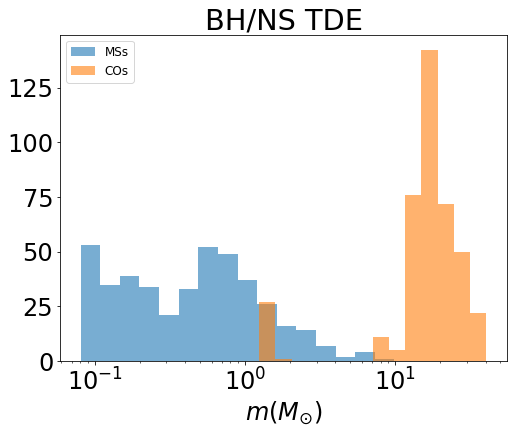

In [3]:
##Mass distribution of BHNS TDE
bhns_tde_msm = []; bhns_tde_com = []
for jj in range(len(paths)):
    bhns_tde_m0 = np.take(all_sscoll[str(jj)]['m0'], index_bhns_tde[jj])
    bhns_tde_m1 = np.take(all_sscoll[str(jj)]['m1'], index_bhns_tde[jj])
    bhns_tde_k0 = np.take(all_sscoll[str(jj)]['k0'], index_bhns_tde[jj])
    bhns_tde_k1 = np.take(all_sscoll[str(jj)]['k1'], index_bhns_tde[jj])
    
    for i in range(len(bhns_tde_k0)):
        if bhns_tde_k0[i] <= 1:
            bhns_tde_msm.append(bhns_tde_m0[i])
        else:
            bhns_tde_com.append(bhns_tde_m0[i])
            
        if bhns_tde_k1[i] <= 1:
            bhns_tde_msm.append(bhns_tde_m1[i])
        else:
            bhns_tde_com.append(bhns_tde_m1[i])
        
        
fig, axs = plt.subplots(figsize = (8,6))

axs.hist(bhns_tde_msm, bins = np.logspace(np.log10(min(bhns_tde_msm)), np.log10(max(bhns_tde_msm)), 17), alpha=0.6, label = 'MSs')
axs.hist(bhns_tde_com, bins = np.logspace(np.log10(min(bhns_tde_com)), np.log10(max(bhns_tde_com)), 15), alpha=0.6, label = 'COs')


axs.set_xlabel(r'$m (M_{\odot})$')
axs.set_xscale('log')
axs.set_title('BH/NS TDE')
axs.legend(loc='best', fontsize=12)

In [4]:
##Check binary types of tidal capture and giant collision binaries
from IPython.display import display_html, display
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)


tc_init = np.zeros([15, 15]); tc_finl = np.zeros([15, 15])
coll_init = np.zeros([15, 15]); coll_finl = np.zeros([15, 15])
for jj in range(len(paths)):
    tc_k0_finl = np.take(prop_finl[str(jj)]['k0'], index_tc_bin[jj])
    tc_k1_finl = np.take(prop_finl[str(jj)]['k1'], index_tc_bin[jj])
    tc_k0_init = np.take(prop_init[str(jj)]['k0'], index_tc_bin[jj])
    tc_k1_init = np.take(prop_init[str(jj)]['k1'], index_tc_bin[jj])
    
    
    coll_k0_finl = np.take(prop_finl[str(jj)]['k0'], index_coll_bin[jj])
    coll_k1_finl = np.take(prop_finl[str(jj)]['k1'], index_coll_bin[jj])
    coll_k0_init = np.take(prop_init[str(jj)]['k0'], index_coll_bin[jj])
    coll_k1_init = np.take(prop_init[str(jj)]['k1'], index_coll_bin[jj])
    

    for i in range(len(tc_k0_init)):
        x_tmp = tc_k0_init[i]; y_tmp = tc_k1_init[i]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        tc_init[xvalue, yvalue]+=1
    
    for x in range(len(tc_k0_finl)):
        x_tmp = tc_k0_finl[x]; y_tmp = tc_k1_finl[x]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        tc_finl[xvalue, yvalue]+=1
    
    for j in range(len(coll_k0_init)):
        x_tmp = coll_k0_init[j]; y_tmp = coll_k1_init[j]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        coll_init[xvalue, yvalue]+=1

    for y in range(len(coll_k0_finl)):
        x_tmp = coll_k0_finl[y]; y_tmp = coll_k1_finl[y]
        if x_tmp < y_tmp: 
            xvalue = x_tmp; yvalue = y_tmp
        else: 
            xvalue = y_tmp; yvalue = x_tmp
            
        coll_finl[xvalue, yvalue]+=1
    

df1 = pd.DataFrame(tc_init, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df2 = pd.DataFrame(tc_finl, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df3 = pd.DataFrame(coll_init, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)
df4 = pd.DataFrame(coll_finl, columns=(np.linspace(0, 14, num=15, dtype=int)), dtype=np.int)

display_side_by_side(df1, df2)
display_side_by_side(df3, df4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,366,237,0,0,0,0,0,0,0,0,0,365,56,18,287
1,0,67,0,0,0,0,0,0,0,0,0,329,110,29,97
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,0,0,33,695,62,170,0,0,0,0,0,0,0,0
1,0,0,1,36,230,33,61,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,3,0,0,0,0,0,0,159,51,15,16
4,0,0,0,0,1,0,1,0,0,0,0,128,34,8,75
5,0,0,0,0,0,0,0,0,0,0,0,19,5,1,10
6,0,0,0,0,0,0,0,0,0,0,0,27,10,3,7
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


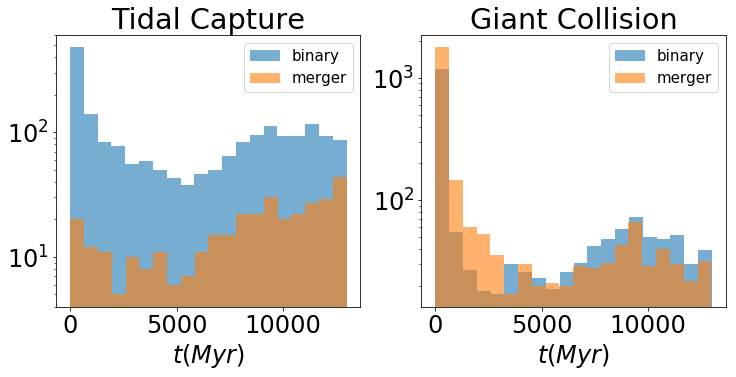

In [8]:
### Check time distribution of tidal capture and giant collision
tc_bin_time = []; tc_des_time = []
coll_bin_time = []; coll_des_time = []
for jj in range(len(paths)):
    tconv = dyn.conv('t', paths[jj]+'initial.conv.sh')

    tc_bin_time_temp = list(np.take(prop_init[str(jj)]['time'], index_tc_bin[jj])*tconv)
    tc_des_time_temp = list(np.take(prop_des[str(jj)]['time'], index_tc_des[jj])*tconv)
    coll_bin_time_temp = list(np.take(prop_init[str(jj)]['time'], index_coll_bin[jj])*tconv)
    coll_des_time_temp = list(np.take(prop_des[str(jj)]['time'], index_coll_des[jj])*tconv)
    
    tc_bin_time = tc_bin_time + tc_bin_time_temp
    tc_des_time = tc_des_time + tc_des_time_temp
    coll_bin_time = coll_bin_time + coll_bin_time_temp
    coll_des_time = coll_des_time + coll_des_time_temp


fig, axs = plt.subplots(ncols = 2, figsize = (12, 5))
axs[0].hist(tc_bin_time, bins = 20, alpha = 0.6, label = 'binary')
axs[0].hist(tc_des_time, bins = 20, alpha = 0.6, label = 'merger')
axs[1].hist(coll_bin_time, bins = 20, alpha = 0.6, label = 'binary')
axs[1].hist(coll_des_time, bins = 20, alpha = 0.6, label = 'merger')

axs[0].set_xlabel(r'$t(Myr)$')
axs[1].set_xlabel(r'$t(Myr)$')

axs[0].set_title('Tidal Capture')
axs[1].set_title('Giant Collision')

axs[0].set_yscale('log')
axs[1].set_yscale('log')

axs[0].legend(loc='best', fontsize=15)
axs[1].legend(loc='best', fontsize=15)

In [5]:
##Extract cluster properties from the tidal capture model and the standard model
dyn_tc = []; bh_tc = []; ns_tc = []
dyn_comp = []; bh_comp = []; ns_comp = []

paths_comp = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/path_oldrvgrid.dat', dtype=str)

for jj in range(len(paths)):
    print(jj)
    dyn_tc.append(np.genfromtxt(paths[jj]+'initial.dyn.dat'))
    #bin_tc.append(np.genfromtxt(paths[jj]+'initial.bin.dat'))
    dyn_comp.append(np.genfromtxt(paths_comp[jj]+'initial.dyn.dat'))
    #bin_comp.append(np.genfromtxt(paths_comp[jj]+'initial.bin.dat'))
    bh_tc.append(np.genfromtxt(paths[jj]+'initial.bh.dat'))
    bh_comp.append(np.genfromtxt(paths_comp[jj]+'initial.bh.dat'))
    ns_tc.append(np.genfromtxt(paths[jj]+'initial.ns.dat'))
    ns_comp.append(np.genfromtxt(paths_comp[jj]+'initial.ns.dat'))
    
#print(ns_tc)
#print(dyn_tc[9][:,3])

0
1
2
3
4
5
6
7
8
9


In [6]:
def addColorbar(
    ax,cmap,
    vmin,vmax,
    label,logflag = 0,
    fontsize=16,cmap_number=0,
    tick_tuple=None):
    if logflag:
        from matplotlib.colors import LogNorm as norm
        ticks = np.linspace(np.log10(vmin),np.log10(vmax),5,endpoint=True)
        tick_labels= [r"$10^{%.1f}$"%tick for tick in ticks]
        ticks = 10**ticks
    else:
        from matplotlib.colors import Normalize as norm
        ticks = np.linspace(vmin,vmax,5,endpoint=True)
        tick_labels= ticks
    
    if tick_tuple is not None:
        ticks,tick_labels = tick_tuple

    fig = ax.get_figure()
    
    ## x,y of bottom left corner, width,height in percentage of figure size
    ## matches the default aspect ratio of matplotlib
    cur_size = fig.get_size_inches()*fig.dpi        

    cur_height = cur_size[1]
    cur_width = cur_size[0]
    offset = 0.00 + cmap_number*(25/cur_width+50/cur_width)

    ax1 = fig.add_axes([0.91 + offset, 0.135, 25./cur_width, 0.75])

    cb1 = matplotlib.colorbar.ColorbarBase(
        ax1, cmap=cmap,
        #extend='both',
        extendfrac=0.05,
        norm=norm(vmin=vmin,vmax=vmax),
        orientation='vertical')


    #cb1.set_label(label,fontsize=fontsize)

    cb1.set_ticks(ticks)
    cb1.set_ticklabels(tick_labels)
    cb1.ax.tick_params(labelsize=fontsize-2)
    return cb1,ax1

/software/anaconda3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'$Binary Fraction$')

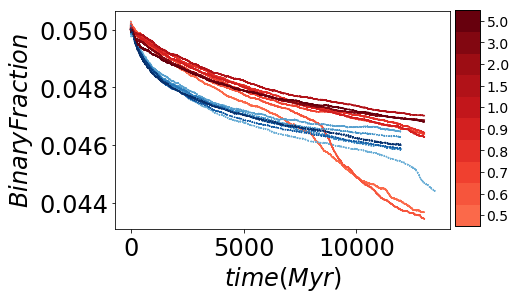

In [8]:
##Compare binary fraction of tidal capture model and standard model
cb = cm.Blues(np.linspace(0.5, 1, 10))
cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5], cb[6], cb[7], cb[8], cb[9]])
cr = cm.Reds(np.linspace(0.5, 1, 10))
cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5], cr[6], cr[7], cr[8], cr[9]])

bin_tc = []; bin_comp = []

fig, ax=plt.subplots()
#plt.figure()
for jj in range(len(paths)):
    if jj != 5 and jj != 7:
        bin_tc=np.genfromtxt(paths[jj]+'initial.bin.dat')
        bin_comp=np.genfromtxt(paths_comp[jj]+'initial.bin.dat')
        N_tc = dyn_tc[jj][:,3]; t_tc = dyn_tc[jj][:,0]; Nb_tc = bin_tc[:,1]
        N_comp = dyn_comp[jj][:,3]; t_comp = dyn_comp[jj][:,0]; Nb_comp = bin_comp[:,1]

        conv_tc = dyn.conv('t', paths[jj]+'initial.conv.sh')
        conv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')

        tmyr_tc = conv_tc*np.array(t_tc)
        tmyr_comp = conv_comp*np.array(t_comp)
        binfrac_tc = np.array(Nb_tc)/np.array(N_tc)
        binfrac_comp = np.array(Nb_comp)/np.array(N_comp)

        ax.plot(tmyr_tc, binfrac_tc, color = cr[jj])
        ax.plot(tmyr_comp, binfrac_comp, ls = ':', color = cb[jj])
        
addColorbar(ax, cmapb, 0, 20, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.,13.,15.,17.,19.],[0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,3.0,5.0]))
addColorbar(ax, cmapr, 0, 20, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.,13.,15.,17.,19.],[0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,3.0,5.0]))

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$Binary Fraction$')

#plt.legend(loc='best', fontsize=12)

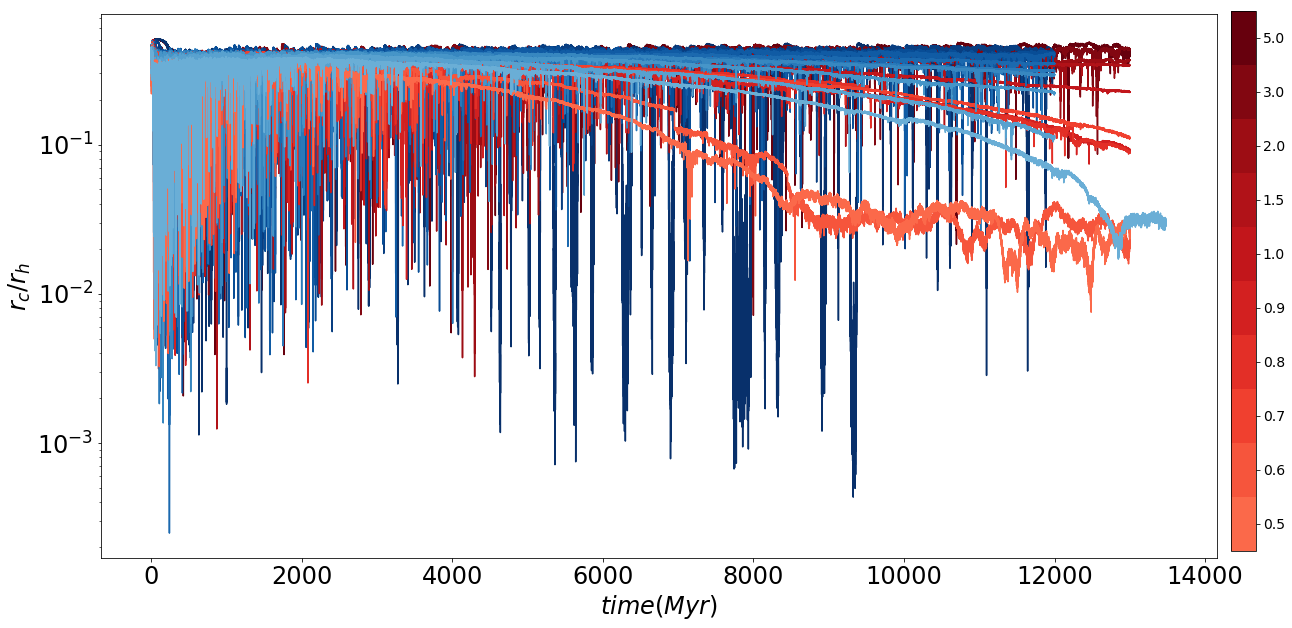

In [11]:
##Compare rc/rh of tidal capture model and standard model
cb = cm.Blues(np.linspace(0.5, 1, 10))
cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5], cb[6], cb[7], cb[8], cb[9]])
cr = cm.Reds(np.linspace(0.5, 1, 10))
cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5], cr[6], cr[7], cr[8], cr[9]])

fig, ax=plt.subplots(figsize=(20, 10))
for jj in range(len(paths)-1, -1, -1):
    conv_tc = dyn.conv('t', paths[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')
    
    rc_tc = dyn_tc[jj][:,7]; rh_tc = dyn_tc[jj][:,20]; t_tc = dyn_tc[jj][:,0]
    rc_comp = dyn_comp[jj][:,7]; rh_comp = dyn_comp[jj][:,20]; t_comp = dyn_comp[jj][:,0]

    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)
    r_ratio_tc = np.array(rc_tc)/np.array(rh_tc)
    r_ratio_comp = np.array(rc_comp)/np.array(rh_comp)

    ax.plot(tmyr_tc, r_ratio_tc, color = cr[jj])
    ax.plot(tmyr_comp, r_ratio_comp, color = cb[jj])
    
addColorbar(ax, cmapr, 0, 20, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.,13.,15.,17.,19.],[0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,3.0,5.0]))

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$r_c/r_h$')
ax.set_yscale('log')
#ax.set_xscale('log')

#plt.legend(loc='best', fontsize=12)

484844.0 484844.0
484844.0 484844.0
484844.0 484844.0
484844.0 484844.0
484844.0 484844.0
484844.0 484844.0
484844.0 484844.0
484844.0 484844.0
484844.0 484844.0
484844.0 484844.0


Text(0,0.5,'$M_{tot}(M_{\\odot})$')

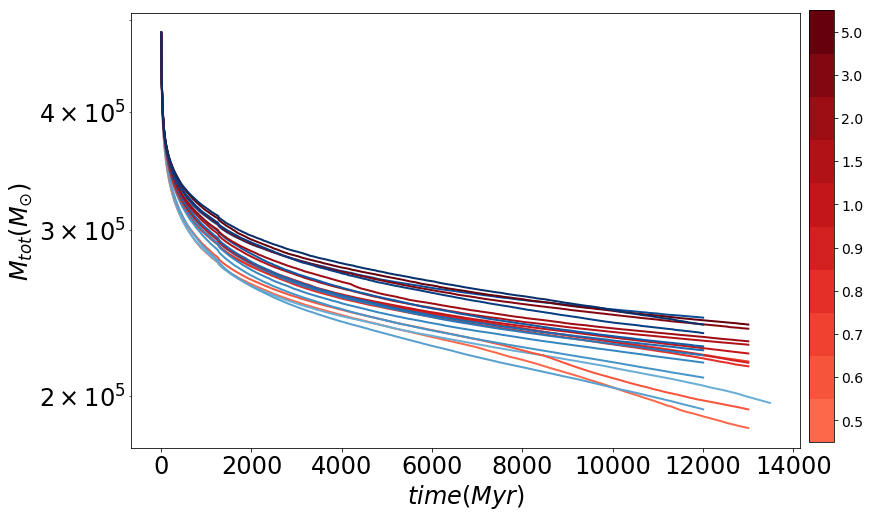

In [7]:
##Compare the mass evolution of the two models
cb = cm.Blues(np.linspace(0.5, 1, 10))
cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5], cb[6], cb[7], cb[8], cb[9]])
cr = cm.Reds(np.linspace(0.5, 1, 10))
cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5], cr[6], cr[7], cr[8], cr[9]])

fig, ax=plt.subplots(figsize=(12, 8))
for jj in range(len(paths)):
    m_tc = dyn_tc[jj][:,4]; t_tc = dyn_tc[jj][:,0]
    m_comp = dyn_comp[jj][:,4]; t_comp = dyn_comp[jj][:,0]

    tconv_tc = dyn.conv('t', paths[jj]+'initial.conv.sh')
    tconv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')
    mconv_tc = dyn.conv('m', paths[jj]+'initial.conv.sh')
    mconv_comp = dyn.conv('m', paths_comp[jj]+'initial.conv.sh')
    print(mconv_tc, mconv_comp)

    tmyr_tc = tconv_tc*np.array(t_tc)
    tmyr_comp = tconv_comp*np.array(t_comp)
    msun_tc = mconv_tc*np.array(m_tc)
    msun_comp = mconv_comp*np.array(m_comp)

    ax.plot(tmyr_tc, msun_tc, lw = 2, color = cr[jj])
    ax.plot(tmyr_comp, msun_comp, lw = 2, color = cb[jj])

addColorbar(ax, cmapr, 0, 20, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.,13.,15.,17.,19.],[0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,3.0,5.0]))

ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$M_{tot}(M_{\odot})$')
#ax.set_legend(loc='best', fontsize=12)

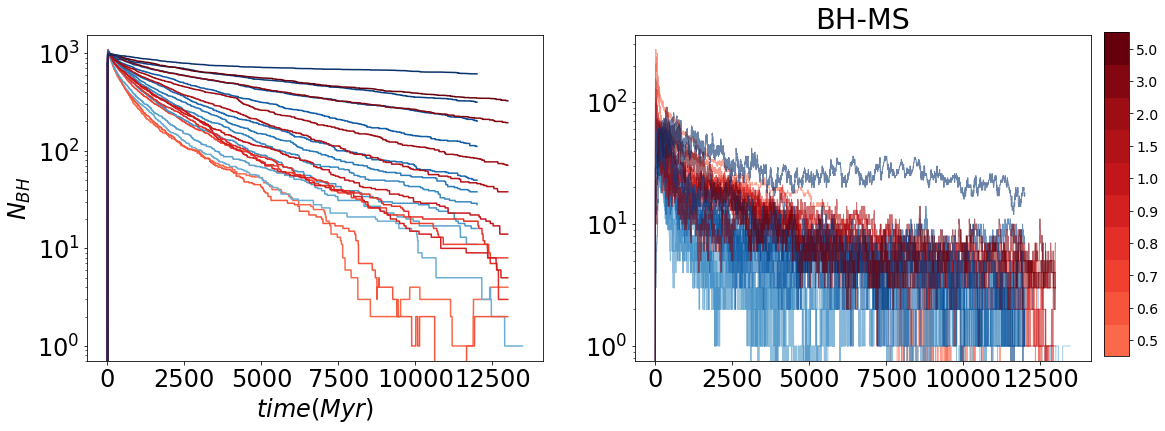

In [7]:
##Comapre number of BH
cb = cm.Blues(np.linspace(0.5, 1, 10))
cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3], cb[4], cb[5], cb[6], cb[7], cb[8], cb[9]])
cr = cm.Reds(np.linspace(0.5, 1, 10))
cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3], cr[4], cr[5], cr[6], cr[7], cr[8], cr[9]])

fig, axs = plt.subplots(ncols = 2, figsize = (18, 6))
for jj in range(len(paths)):
    t_tc = bh_tc[jj][:,1]; Nbh_tc = bh_tc[jj][:,2]
    Nbhms_tc = bh_tc[jj][:,10]; Nbhwd_tc = bh_tc[jj][:,8]
    
    t_comp = bh_comp[jj][:,1]; Nbh_comp = bh_comp[jj][:,2]
    Nbhms_comp = bh_comp[jj][:,10]; Nbhwd_comp = bh_comp[jj][:,8]
    
    conv_tc = dyn.conv('t', paths[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', paths_comp[jj]+'initial.conv.sh')
    
    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)
    

    axs[0].plot(tmyr_tc, Nbh_tc, color = cr[jj])
    axs[0].plot(tmyr_comp, Nbh_comp, color = cb[jj])
    
    axs[1].plot(tmyr_tc, Nbhms_tc, color = cr[jj], lw=1, alpha=0.6)
    axs[1].plot(tmyr_comp, Nbhms_comp, color = cb[jj], lw=1, alpha=0.6)
    
    #axs[2].plot(tmyr_tc, Nbhwd_tc, color = cr[jj], lw=1, alpha=0.6)
    #axs[2].plot(tmyr_comp, Nbhwd_comp, color = cb[jj], lw=1, alpha=0.6)

addColorbar(axs[1], cmapr, 0, 20, label=None, tick_tuple=([1.,3.,5.,7.,9.,11.,13.,15.,17.,19.],[0.5,0.6,0.7,0.8,0.9,1.0,1.5,2.0,3.0,5.0]))

    
axs[0].set_xlabel(r'$time(Myr)$')
axs[0].set_ylabel(r'$N_{BH}$')
axs[1].set_title('BH-MS')
axs[0].set_yscale('log')
axs[1].set_yscale('log')

#axs[2].set_title('BH-WD')
#axs[0].legend(loc='best', fontsize = 12)    
#axs[1].legend(loc='best', fontsize = 12)
#axs[1].set_yscale('symlog')
#axs[1].set_ylim(-1, 30)


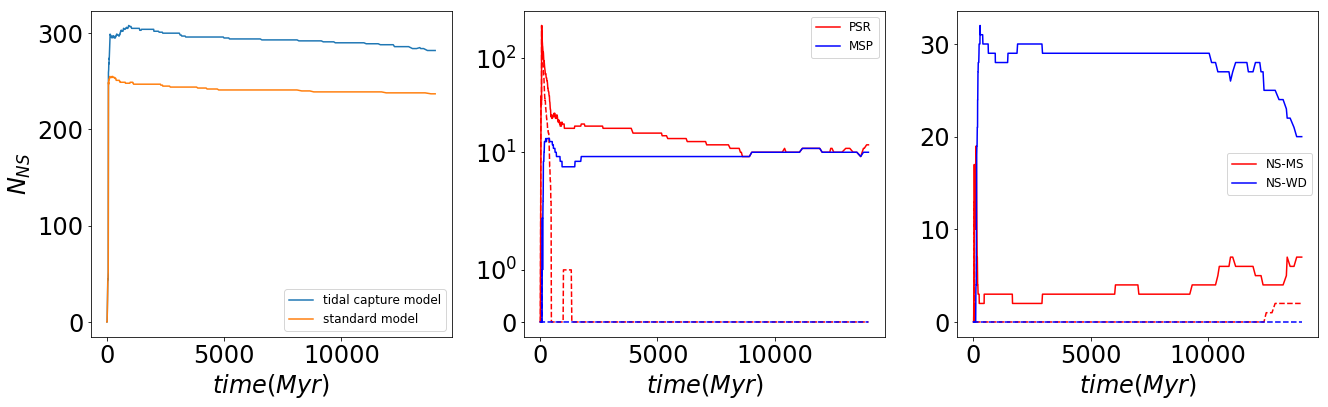

In [43]:
##Compare the number of pulsars and neutron star binaries in general in the two models
t_tc = ns_tc[:,0]; Nns_tc = ns_tc[:,1]
Nnsms_tc = ns_tc[:,10]; Nnswd_tc = ns_tc[:,9]
Npsr_tc = ns_tc[:,5]; Nmsp_tc = ns_tc[:,6]

t_comp = ns_comp[:,0]; Nns_comp = ns_comp[:,1]
Nnsms_comp = ns_comp[:,10]; Nnswd_comp = ns_comp[:,9]
Npsr_comp = ns_comp[:,5]; Nmsp_comp = ns_comp[:,6]

conv_tc = dyn.conv('t', path_tc+'initial.conv.sh')
conv_comp = dyn.conv('t', path_comp+'initial.conv.sh')

tmyr_tc = conv_tc*np.array(t_tc)
tmyr_comp = conv_comp*np.array(t_comp)

cs = ['r', 'b']
fig, axs = plt.subplots(ncols = 3, figsize = (22, 6))
axs[0].plot(tmyr_tc, Nns_tc, label = 'tidal capture model')
axs[0].plot(tmyr_comp, Nns_comp, label = 'standard model')
axs[0].legend(loc='best', fontsize = 12)
axs[0].set_xlabel(r'$time(Myr)$')
axs[0].set_ylabel(r'$N_{NS}$')

axs[1].plot(tmyr_tc, Npsr_tc, color = cs[0], label = 'PSR')
axs[1].plot(tmyr_comp, Npsr_comp, ls = '--', color = cs[0])
axs[1].plot(tmyr_tc, Nmsp_tc, color = cs[1], label = 'MSP')
axs[1].plot(tmyr_comp, Nmsp_comp, ls = '--', color = cs[1])
axs[1].set_yscale('symlog')
axs[1].set_xlabel(r'$time(Myr)$')
#axs[1].set_ylabel(r'$$')
axs[1].legend(loc='best', fontsize = 12)

axs[2].plot(tmyr_tc, Nnsms_tc, color = cs[0], label = 'NS-MS')
axs[2].plot(tmyr_comp, Nnsms_comp, ls = '--', color = cs[0])
axs[2].plot(tmyr_tc, Nnswd_tc, color = cs[1], label = 'NS-WD')
axs[2].plot(tmyr_comp, Nnswd_comp, ls = '--', color = cs[1])
axs[2].set_xlabel(r'$time(Myr)$')
#axs[2].set_ylabel(r'$NS\ binaries$')
axs[2].legend(loc='center right', fontsize = 12)

##Check why there are more NSs and pulsars and NS binaries in the tidal capture model
##How many MSPs in the NS-MS and NS-WD binaries

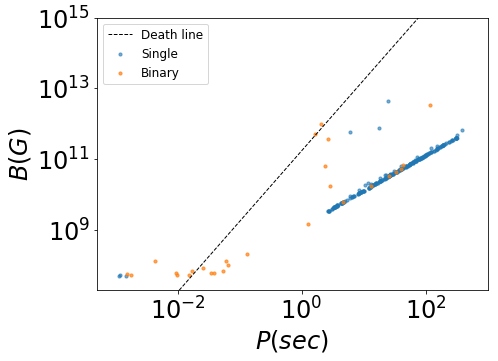

In [45]:
##Check the B-P plot
snaps_tc = dyn.get_snapshots(testpath+'initial')
lastsnap_tc = snaps_tc[-1]
B_s, B_b, P_s, P_b = ns.get_snap_BP(lastsnap_tc)

x=np.logspace(-4.0, 2.0, num=50)

plt.figure(figsize = (7, 5))
plt.plot(x, (x**2)*(0.17*10**12), 'k--', lw = 1, label = 'Death line')
plt.scatter(P_s, B_s, s=10, label = 'Single', alpha = 0.6)
plt.scatter(P_b, B_b, s=10, label = 'Binary', alpha = 0.7)

plt.xlim(0.5*10**-3, 1000.)
plt.ylim(2*10**7, 10**15)

plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'$P(sec)$')
plt.ylabel(r'$B(G)$')

plt.legend(loc='best', fontsize=12)

##What's the straightline that all the pulsars stop at?

0
1
2
3


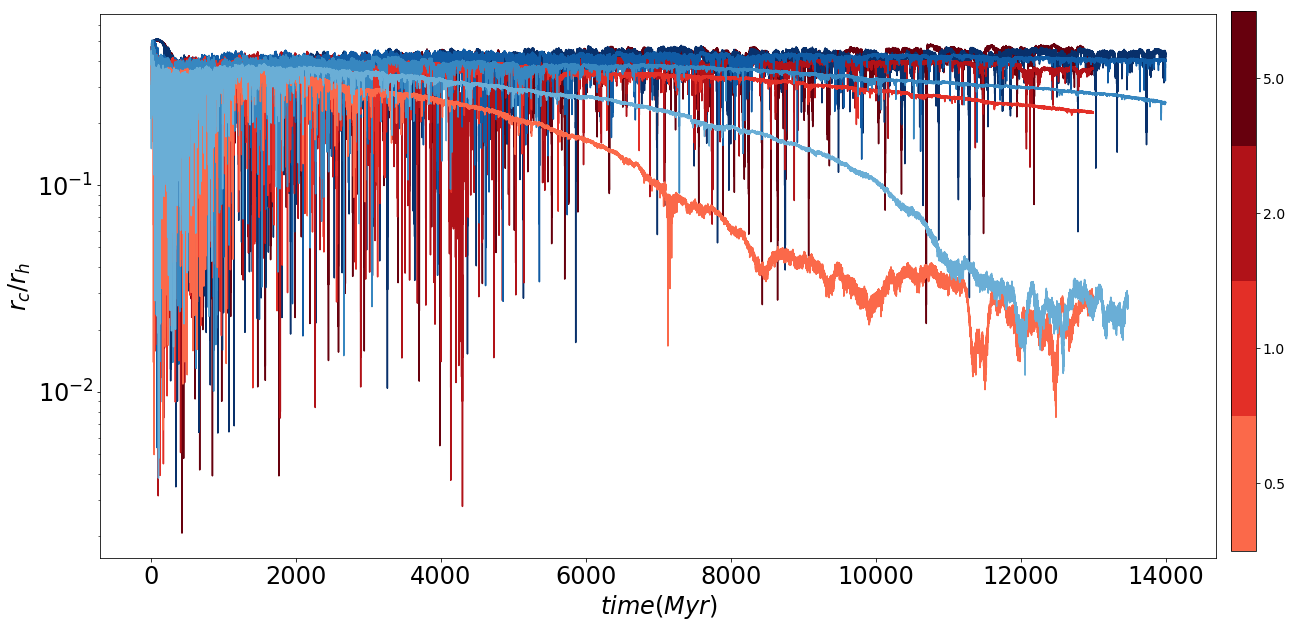

In [7]:
dyn_tc_sel = []; bh_tc_sel = []; ns_tc_sel = []
dyn_comp_sel = []; bh_comp_sel = []; ns_comp_sel = []

path_tc_select = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/path_rv_short.dat', dtype=str)
path_comp_select = np.genfromtxt('/projects/b1095/syr904/cmc/cmc-mpi-tidalcapture/rvgrid/path_maingrid_select.dat', dtype=str)

for jj in range(len(path_tc_select)):
    print(jj)
    dyn_tc_sel.append(np.genfromtxt(path_tc_select[jj]+'initial.dyn.dat'))
    dyn_comp_sel.append(np.genfromtxt(path_comp_select[jj]+'initial.dyn.dat'))
    bh_tc_sel.append(np.genfromtxt(path_tc_select[jj]+'initial.bh.dat'))
    bh_comp_sel.append(np.genfromtxt(path_comp_select[jj]+'initial.bh.dat'))
    ns_tc_sel.append(np.genfromtxt(path_tc_select[jj]+'initial.ns.dat'))
    ns_comp_sel.append(np.genfromtxt(path_comp_select[jj]+'initial.ns.dat'))

    
##Compare rc/rh of tidal capture model and standard model
cb = cm.Blues(np.linspace(0.5, 1, 4))
cmapb=matplotlib.colors.ListedColormap([cb[0], cb[1], cb[2], cb[3]])
cr = cm.Reds(np.linspace(0.5, 1, 4))
cmapr=matplotlib.colors.ListedColormap([cr[0], cr[1], cr[2], cr[3]])

fig, ax=plt.subplots(figsize=(20, 10))
for jj in range(len(path_tc_select)-1, -1, -1):
    conv_tc = dyn.conv('t', path_tc_select[jj]+'initial.conv.sh')
    conv_comp = dyn.conv('t', path_comp_select[jj]+'initial.conv.sh')
    
    rc_tc = dyn_tc_sel[jj][:,7]; rh_tc = dyn_tc_sel[jj][:,20]; t_tc = dyn_tc_sel[jj][:,0]
    rc_comp = dyn_comp_sel[jj][:,7]; rh_comp = dyn_comp_sel[jj][:,20]; t_comp = dyn_comp_sel[jj][:,0]

    tmyr_tc = conv_tc*np.array(t_tc)
    tmyr_comp = conv_comp*np.array(t_comp)
    r_ratio_tc = np.array(rc_tc)/np.array(rh_tc)
    r_ratio_comp = np.array(rc_comp)/np.array(rh_comp)

    ax.plot(tmyr_tc, r_ratio_tc, color = cr[jj])
    ax.plot(tmyr_comp, r_ratio_comp, color = cb[jj])
    
addColorbar(ax, cmapr, 0, 8, label=None, tick_tuple=([1.,3.,5.,7.],[0.5,1.0,2.0,5.0]))

ax.set_xlabel(r'$time(Myr)$')
ax.set_ylabel(r'$r_c/r_h$')
ax.set_yscale('log')
#ax.set_xscale('log')

#plt.legend(loc='best', fontsize=12)